In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from utils import *

%matplotlib inline

In [2]:
data = pd.read_csv('vodafone_data.csv')

In [3]:
data.head()

Date       Open       High        Low      Close   Volume
0  2016-02-11  29.330000  29.510000  29.030001  29.270000  4805000
1  2016-02-12  29.520000  29.950001  29.410000  29.900000  3116500
2  2016-02-16  29.950001  30.420000  29.900000  30.260000  4037900
3  2016-02-17  31.000000  31.320000  30.900000  31.090000  4313800
4  2016-02-18  31.090000  31.150000  30.920000  30.959999  3522800

## Експлоративний аналіз даних

In [4]:
data['Date'] = pd.to_datetime(data['Date']).dt.date
data['Date_index'] = pd.DatetimeIndex(data.Date)

In [5]:
data['year'] = pd.to_datetime(data['Date']).dt.year
data['quarter'] = pd.to_datetime(data['Date']).dt.quarter
data['month'] = pd.to_datetime(data['Date']).dt.month

In [6]:
data.Date.agg({min, max})

max    2021-02-11
min    2016-02-11
Name: Date, dtype: object

In [7]:
data.shape

(1260, 10)

### Розподіл значень ряду по роках

#### Розподіл кількості значень ряду по роках

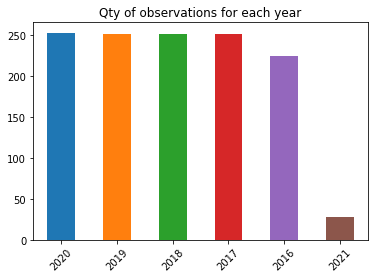

In [8]:
data.year.value_counts().plot(kind='bar', rot='45');
plt.title('Qty of observations for each year');

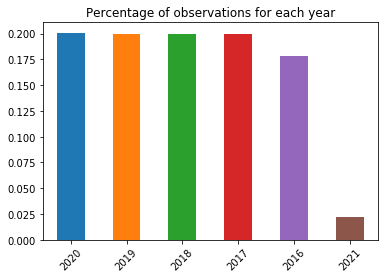

In [9]:
data.year.value_counts(normalize=True).plot(kind='bar', rot='45');
plt.title('Percentage of observations for each year');

##### Бачимо, що значення часового ряду розподілені практично рівномірно по роках

#### Розподіл значень ряду

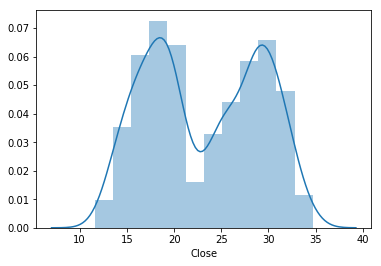

In [10]:
sns.distplot(data.Close);

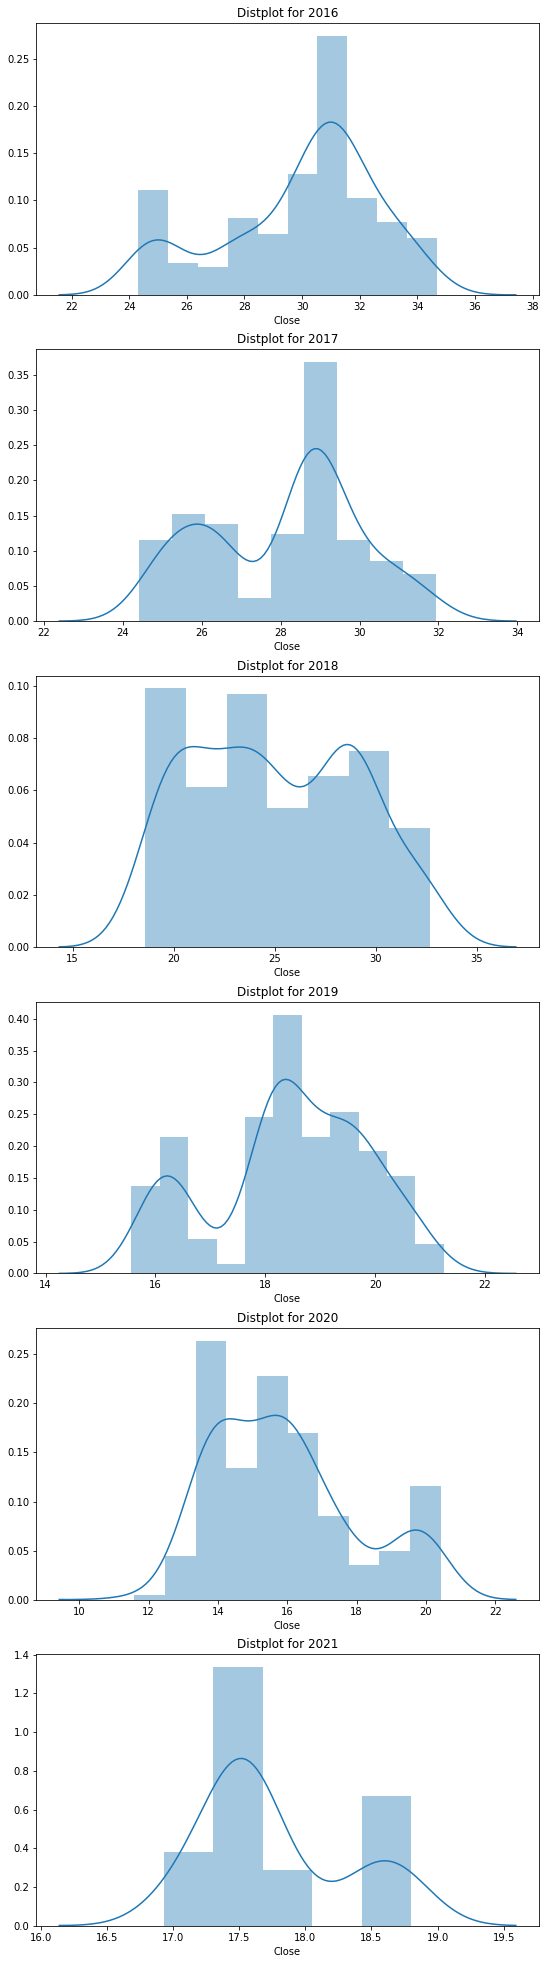

In [11]:
fig, axs = plt.subplots(nrows=data.year.nunique(), ncols=1, figsize=(9, 35))

for idx, year in enumerate(data.year.unique()):
    sns.distplot(data.loc[data.year == year, 'Close'], ax=axs[idx]);
    axs[idx].set_title('Distplot for {}'.format(year));

##### Розподіл значень по роках дає певні "натяки" на наявність негативного тренду

### Аналіз пропущених значень

In [12]:
missing_dates = pd.date_range(start='2016-02-11', end='2021-02-11', freq='D').difference(data.Date)

In [13]:
# we have 568 missing dates
missing_dates.nunique()

568

In [14]:
missing_dates

DatetimeIndex(['2016-02-13', '2016-02-14', '2016-02-15', '2016-02-20',
               '2016-02-21', '2016-02-27', '2016-02-28', '2016-03-05',
               '2016-03-06', '2016-03-12',
               ...
               '2021-01-10', '2021-01-16', '2021-01-17', '2021-01-18',
               '2021-01-23', '2021-01-24', '2021-01-30', '2021-01-31',
               '2021-02-06', '2021-02-07'],
              dtype='datetime64[ns]', length=568, freq=None)

In [15]:
missing_dates = pd.DataFrame(missing_dates, columns=['date'])
missing_dates['year'] = missing_dates['date'].dt.year

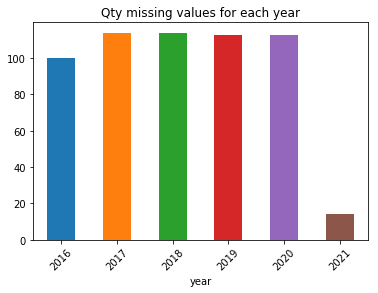

In [16]:
missing_dates.groupby('year').date.count().plot(kind='bar', rot='45');
plt.title('Qty missing values for each year');

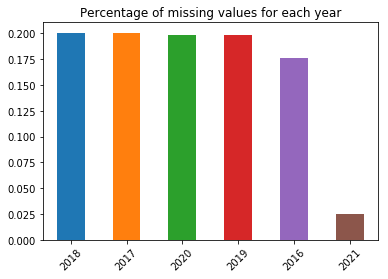

In [17]:
missing_dates.year.value_counts(normalize=True).plot(kind='bar', rot='45');
plt.title('Percentage of missing values for each year');

In [18]:
missing_dates['month'] = missing_dates['date'].dt.month
missing_dates['day'] = missing_dates['date'].dt.day

In [19]:
missing_dates.head()

date  year  month  day
0 2016-02-13  2016      2   13
1 2016-02-14  2016      2   14
2 2016-02-15  2016      2   15
3 2016-02-20  2016      2   20
4 2016-02-21  2016      2   21

In [20]:
missing_dates.day.value_counts(normalize=True).head()

25    0.040493
4     0.038732
1     0.036972
2     0.035211
3     0.035211
Name: day, dtype: float64

In [21]:
missing_dates.month.value_counts(normalize=True).head()

1     0.093310
12    0.091549
7     0.088028
9     0.086268
5     0.084507
Name: month, dtype: float64

### Лінійна інтерполяція для обробки пропущених значень

In [22]:
data.head()

Date       Open       High        Low      Close   Volume Date_index  \
0  2016-02-11  29.330000  29.510000  29.030001  29.270000  4805000 2016-02-11   
1  2016-02-12  29.520000  29.950001  29.410000  29.900000  3116500 2016-02-12   
2  2016-02-16  29.950001  30.420000  29.900000  30.260000  4037900 2016-02-16   
3  2016-02-17  31.000000  31.320000  30.900000  31.090000  4313800 2016-02-17   
4  2016-02-18  31.090000  31.150000  30.920000  30.959999  3522800 2016-02-18   

   year  quarter  month  
0  2016        1      2  
1  2016        1      2  
2  2016        1      2  
3  2016        1      2  
4  2016        1      2

In [23]:
data_no_missing = data.copy(deep=True)

In [24]:
data_no_missing.head()

Date       Open       High        Low      Close   Volume Date_index  \
0  2016-02-11  29.330000  29.510000  29.030001  29.270000  4805000 2016-02-11   
1  2016-02-12  29.520000  29.950001  29.410000  29.900000  3116500 2016-02-12   
2  2016-02-16  29.950001  30.420000  29.900000  30.260000  4037900 2016-02-16   
3  2016-02-17  31.000000  31.320000  30.900000  31.090000  4313800 2016-02-17   
4  2016-02-18  31.090000  31.150000  30.920000  30.959999  3522800 2016-02-18   

   year  quarter  month  
0  2016        1      2  
1  2016        1      2  
2  2016        1      2  
3  2016        1      2  
4  2016        1      2

In [25]:
data_no_missing = data_no_missing.set_index('Date_index').asfreq('D')

In [26]:
data_no_missing.head()

Date   Open       High        Low  Close     Volume    year  \
Date_index                                                                      
2016-02-11  2016-02-11  29.33  29.510000  29.030001  29.27  4805000.0  2016.0   
2016-02-12  2016-02-12  29.52  29.950001  29.410000  29.90  3116500.0  2016.0   
2016-02-13         NaN    NaN        NaN        NaN    NaN        NaN     NaN   
2016-02-14         NaN    NaN        NaN        NaN    NaN        NaN     NaN   
2016-02-15         NaN    NaN        NaN        NaN    NaN        NaN     NaN   

            quarter  month  
Date_index                  
2016-02-11      1.0    2.0  
2016-02-12      1.0    2.0  
2016-02-13      NaN    NaN  
2016-02-14      NaN    NaN  
2016-02-15      NaN    NaN

In [27]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data_no_missing[col] = data_no_missing[col].interpolate()

In [28]:
data_no_missing.head()

Date       Open       High        Low  Close     Volume  \
Date_index                                                                  
2016-02-11  2016-02-11  29.330000  29.510000  29.030001  29.27  4805000.0   
2016-02-12  2016-02-12  29.520000  29.950001  29.410000  29.90  3116500.0   
2016-02-13         NaN  29.627500  30.067501  29.532500  29.99  3346850.0   
2016-02-14         NaN  29.735000  30.185001  29.655000  30.08  3577200.0   
2016-02-15         NaN  29.842501  30.302500  29.777500  30.17  3807550.0   

              year  quarter  month  
Date_index                          
2016-02-11  2016.0      1.0    2.0  
2016-02-12  2016.0      1.0    2.0  
2016-02-13     NaN      NaN    NaN  
2016-02-14     NaN      NaN    NaN  
2016-02-15     NaN      NaN    NaN

In [29]:
data_no_missing = data_no_missing.reset_index(drop=False)

In [30]:
data_no_missing.head(3)

Date_index        Date     Open       High        Low  Close     Volume  \
0 2016-02-11  2016-02-11  29.3300  29.510000  29.030001  29.27  4805000.0   
1 2016-02-12  2016-02-12  29.5200  29.950001  29.410000  29.90  3116500.0   
2 2016-02-13         NaN  29.6275  30.067501  29.532500  29.99  3346850.0   

     year  quarter  month  
0  2016.0      1.0    2.0  
1  2016.0      1.0    2.0  
2     NaN      NaN    NaN

In [31]:
data_no_missing['Date'] = pd.to_datetime(data_no_missing['Date_index']).dt.date
data_no_missing['year'] = pd.to_datetime(data_no_missing['Date']).dt.year
data_no_missing['quarter'] = pd.to_datetime(data_no_missing['Date']).dt.quarter
data_no_missing['month'] = pd.to_datetime(data_no_missing['Date']).dt.month

In [32]:
data_no_missing.head()

Date_index        Date       Open       High        Low  Close     Volume  \
0 2016-02-11  2016-02-11  29.330000  29.510000  29.030001  29.27  4805000.0   
1 2016-02-12  2016-02-12  29.520000  29.950001  29.410000  29.90  3116500.0   
2 2016-02-13  2016-02-13  29.627500  30.067501  29.532500  29.99  3346850.0   
3 2016-02-14  2016-02-14  29.735000  30.185001  29.655000  30.08  3577200.0   
4 2016-02-15  2016-02-15  29.842501  30.302500  29.777500  30.17  3807550.0   

   year  quarter  month  
0  2016        1      2  
1  2016        1      2  
2  2016        1      2  
3  2016        1      2  
4  2016        1      2

### Аналіз наявності викидів в даних

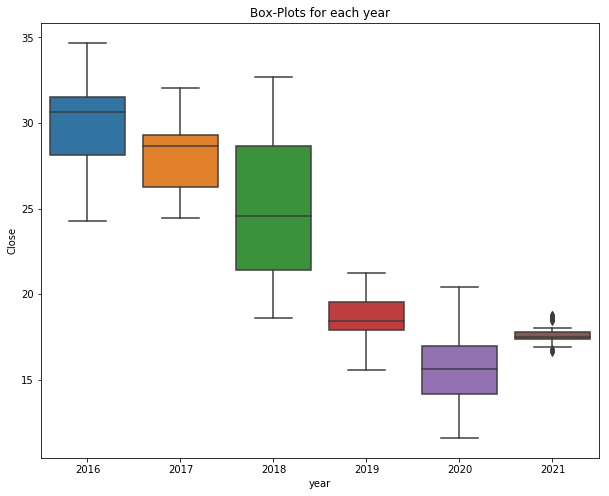

In [33]:
fig = plt.figure(figsize=(10, 8))
sns.boxplot(data=data_no_missing, x=data_no_missing.year, y='Close');
plt.title('Box-Plots for each year');

#### Бачимо, що часовий ряд є досить "чистим", також проглядається негативний тренд

### Аналіз наявності тренду, сезонності, циклічності

#### Візуалізація часового ряду

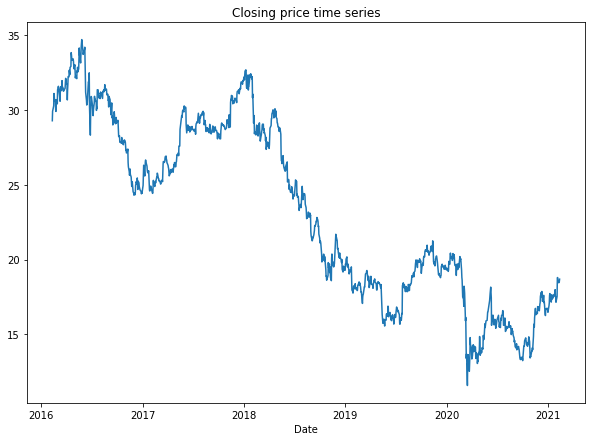

In [34]:
data_no_missing.set_index('Date').Close.plot(title='Closing price time series', figsize=(10, 7));

#### Візуалізація значень часового ряду у розбитті по рокам

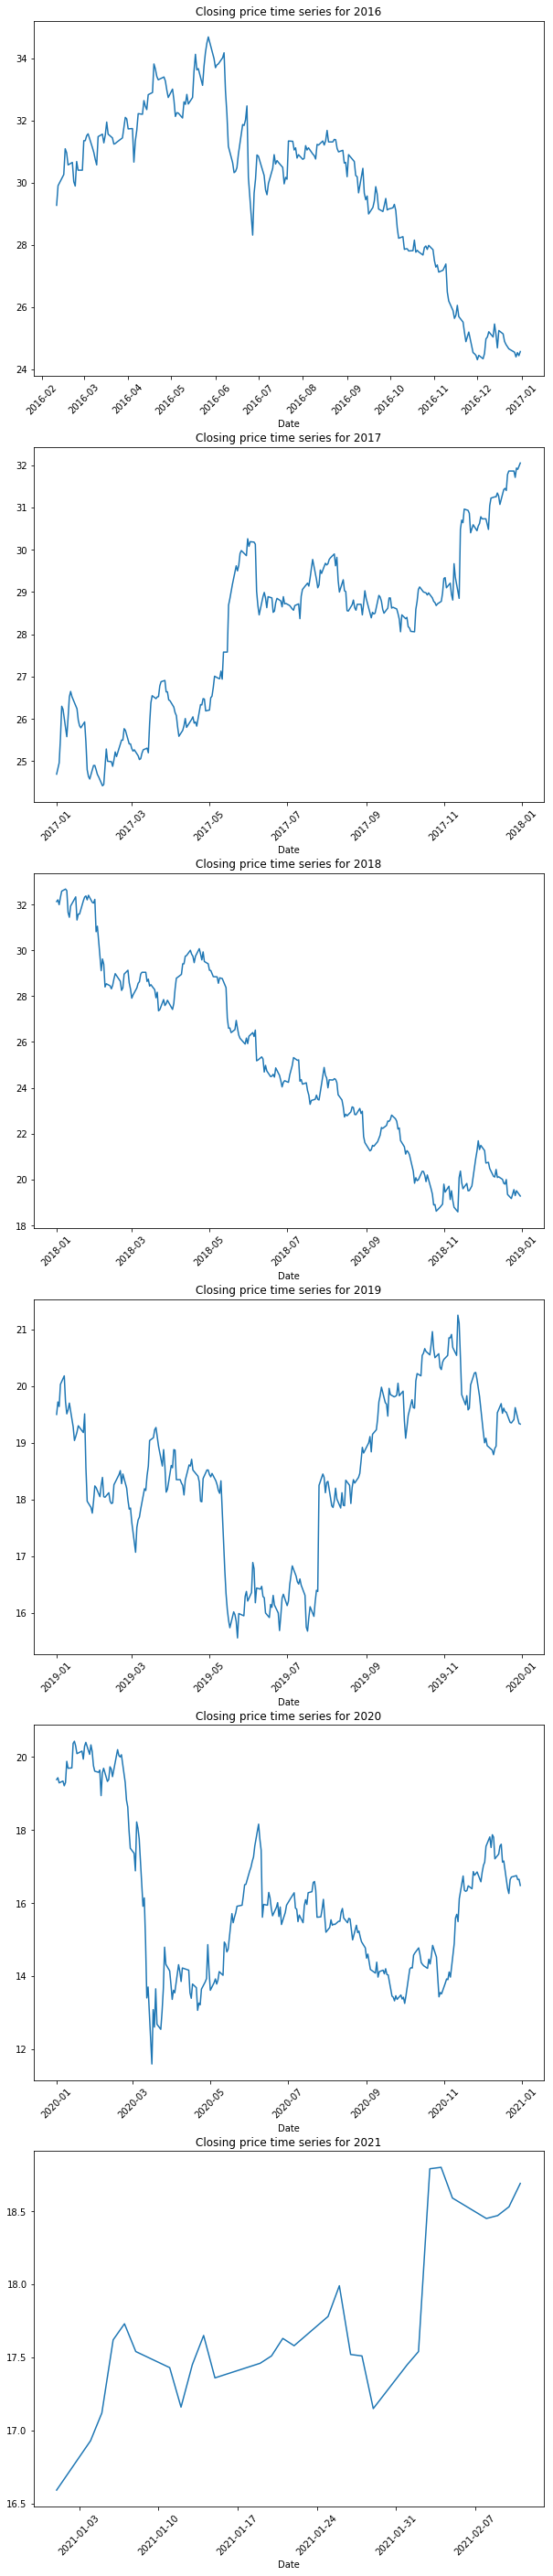

In [35]:
fig, axs = plt.subplots(nrows=data.year.nunique(), ncols=1, figsize=(10, 50))

for idx, year in enumerate(data.year.unique()):
    
    data_no_missing[data_no_missing.year == year].set_index('Date').Close.plot(
        title='Closing price time series for {}'.format(year), ax=axs[idx], rot='45');

#### Поквартальна візуалізація значень часового ряду

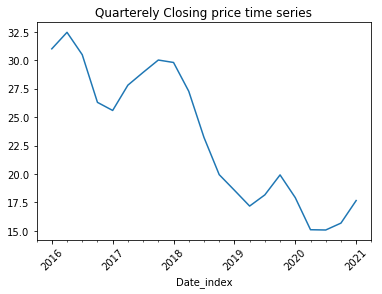

In [36]:
data_no_missing.set_index('Date_index').Close.resample('Q').mean().plot(
        title='Quarterely Closing price time series', rot='45');

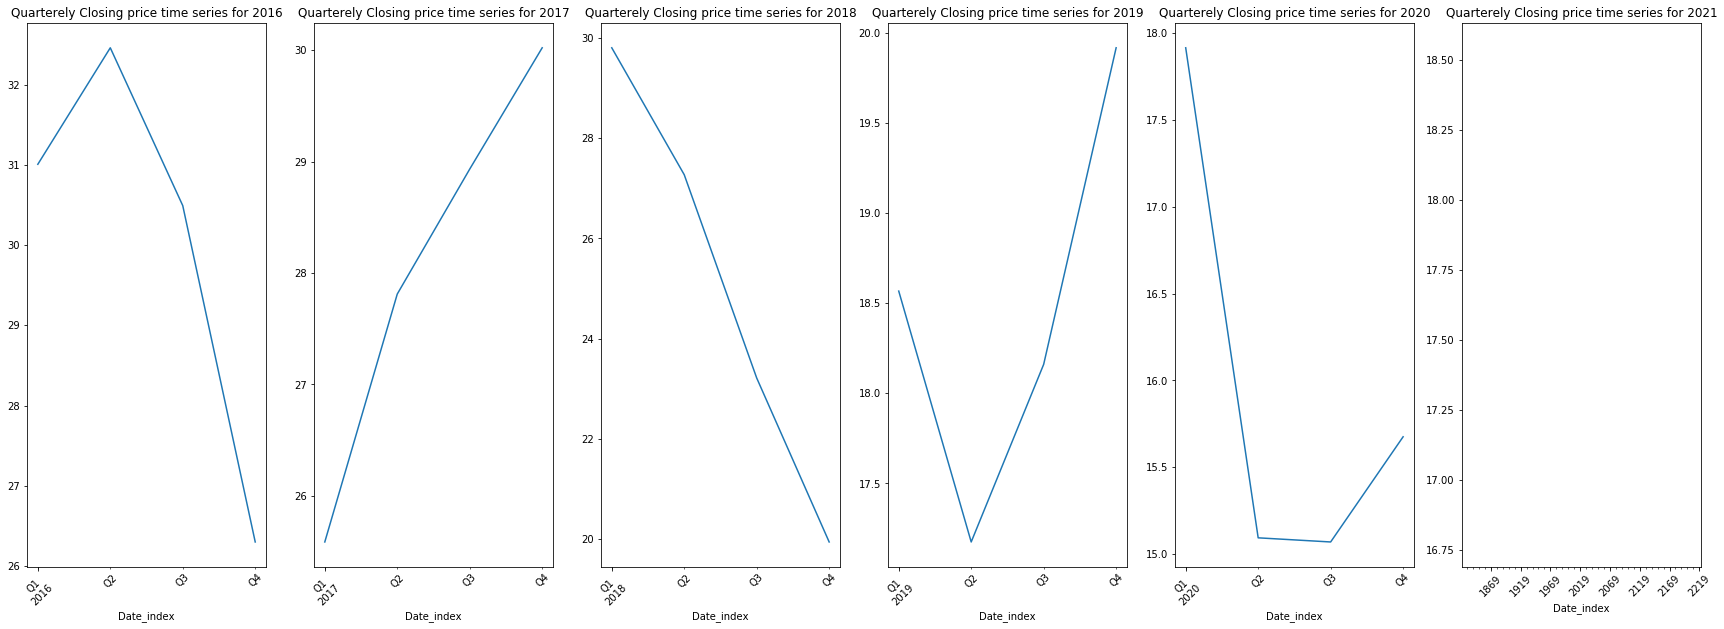

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=data.year.nunique(), figsize=(30, 10))

for idx, year in enumerate(data.year.unique()):
    
    data_no_missing[data_no_missing.year == year].set_index('Date_index').Close.resample('Q').mean().plot(
        title='Quarterely Closing price time series for {}'.format(year), ax=axs[idx], rot='45');

#### Помісячна візуалізація значень часового ряду

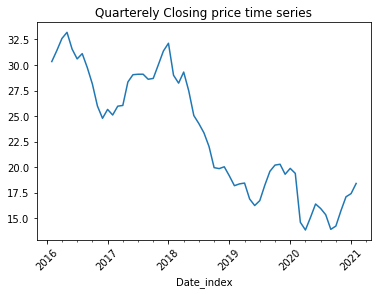

In [38]:
data_no_missing.set_index('Date_index').Close.resample('M').mean().plot(
        title='Quarterely Closing price time series', rot='45');

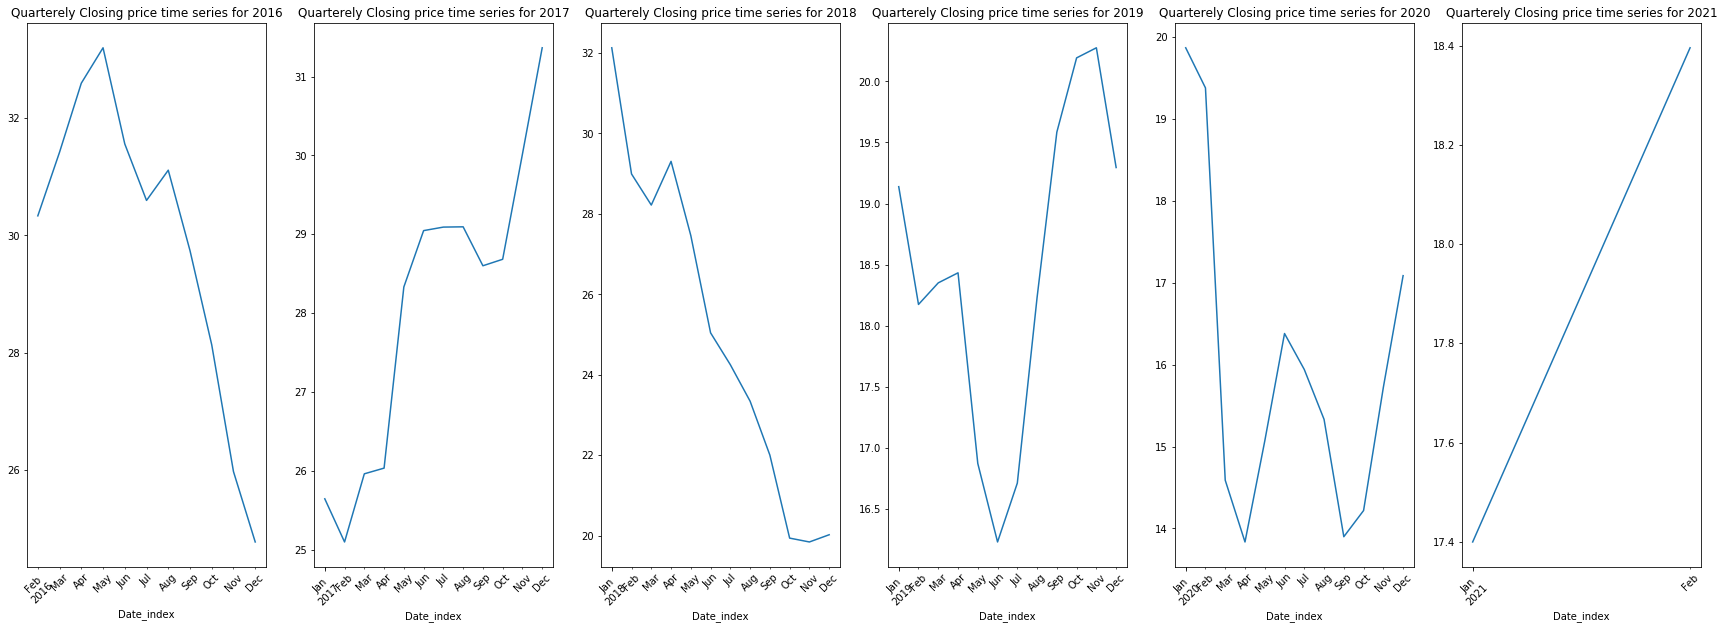

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=data.year.nunique(), figsize=(30, 10))

for idx, year in enumerate(data.year.unique()):
    
    data_no_missing[data_no_missing.year == year].set_index('Date_index').Close.resample('M').mean().plot(
        title='Quarterely Closing price time series for {}'.format(year), ax=axs[idx], rot='45');

##### Наведені графіки свідчать про наявність так званого "mean-revesring" тренду

### Перевірка на стаціонарність

#### Тест Дікі-Фулера

In [40]:
stationarity_test(data_no_missing.Close, smt.adfuller)

{'adfuller_statistics': -1.2810249204236732,
 'adfuller_p_value': 0.6378081111339096,
 'adfuller_critical_values': {'1%': -3.4339382310452033,
  '5%': -2.863125003847544,
  '10%': -2.56761380228936}}

#### KPSS тест

In [41]:
stationarity_test(data_no_missing.Close, smt.kpss)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


{'kpss_statistics': 5.98948825089506,
 'kpss_p_value': 0.01,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Бачимо, що вихідний часовий ряд не є стаціонарним

### Декомпозиція часового ряду

In [42]:
data_no_missing.head(1)

Date_index        Date   Open   High        Low  Close     Volume  year  \
0 2016-02-11  2016-02-11  29.33  29.51  29.030001  29.27  4805000.0  2016   

   quarter  month  
0        1      2

In [43]:
data_no_missing = data_no_missing.set_index('Date_index')

#### Additive model

##### period=5

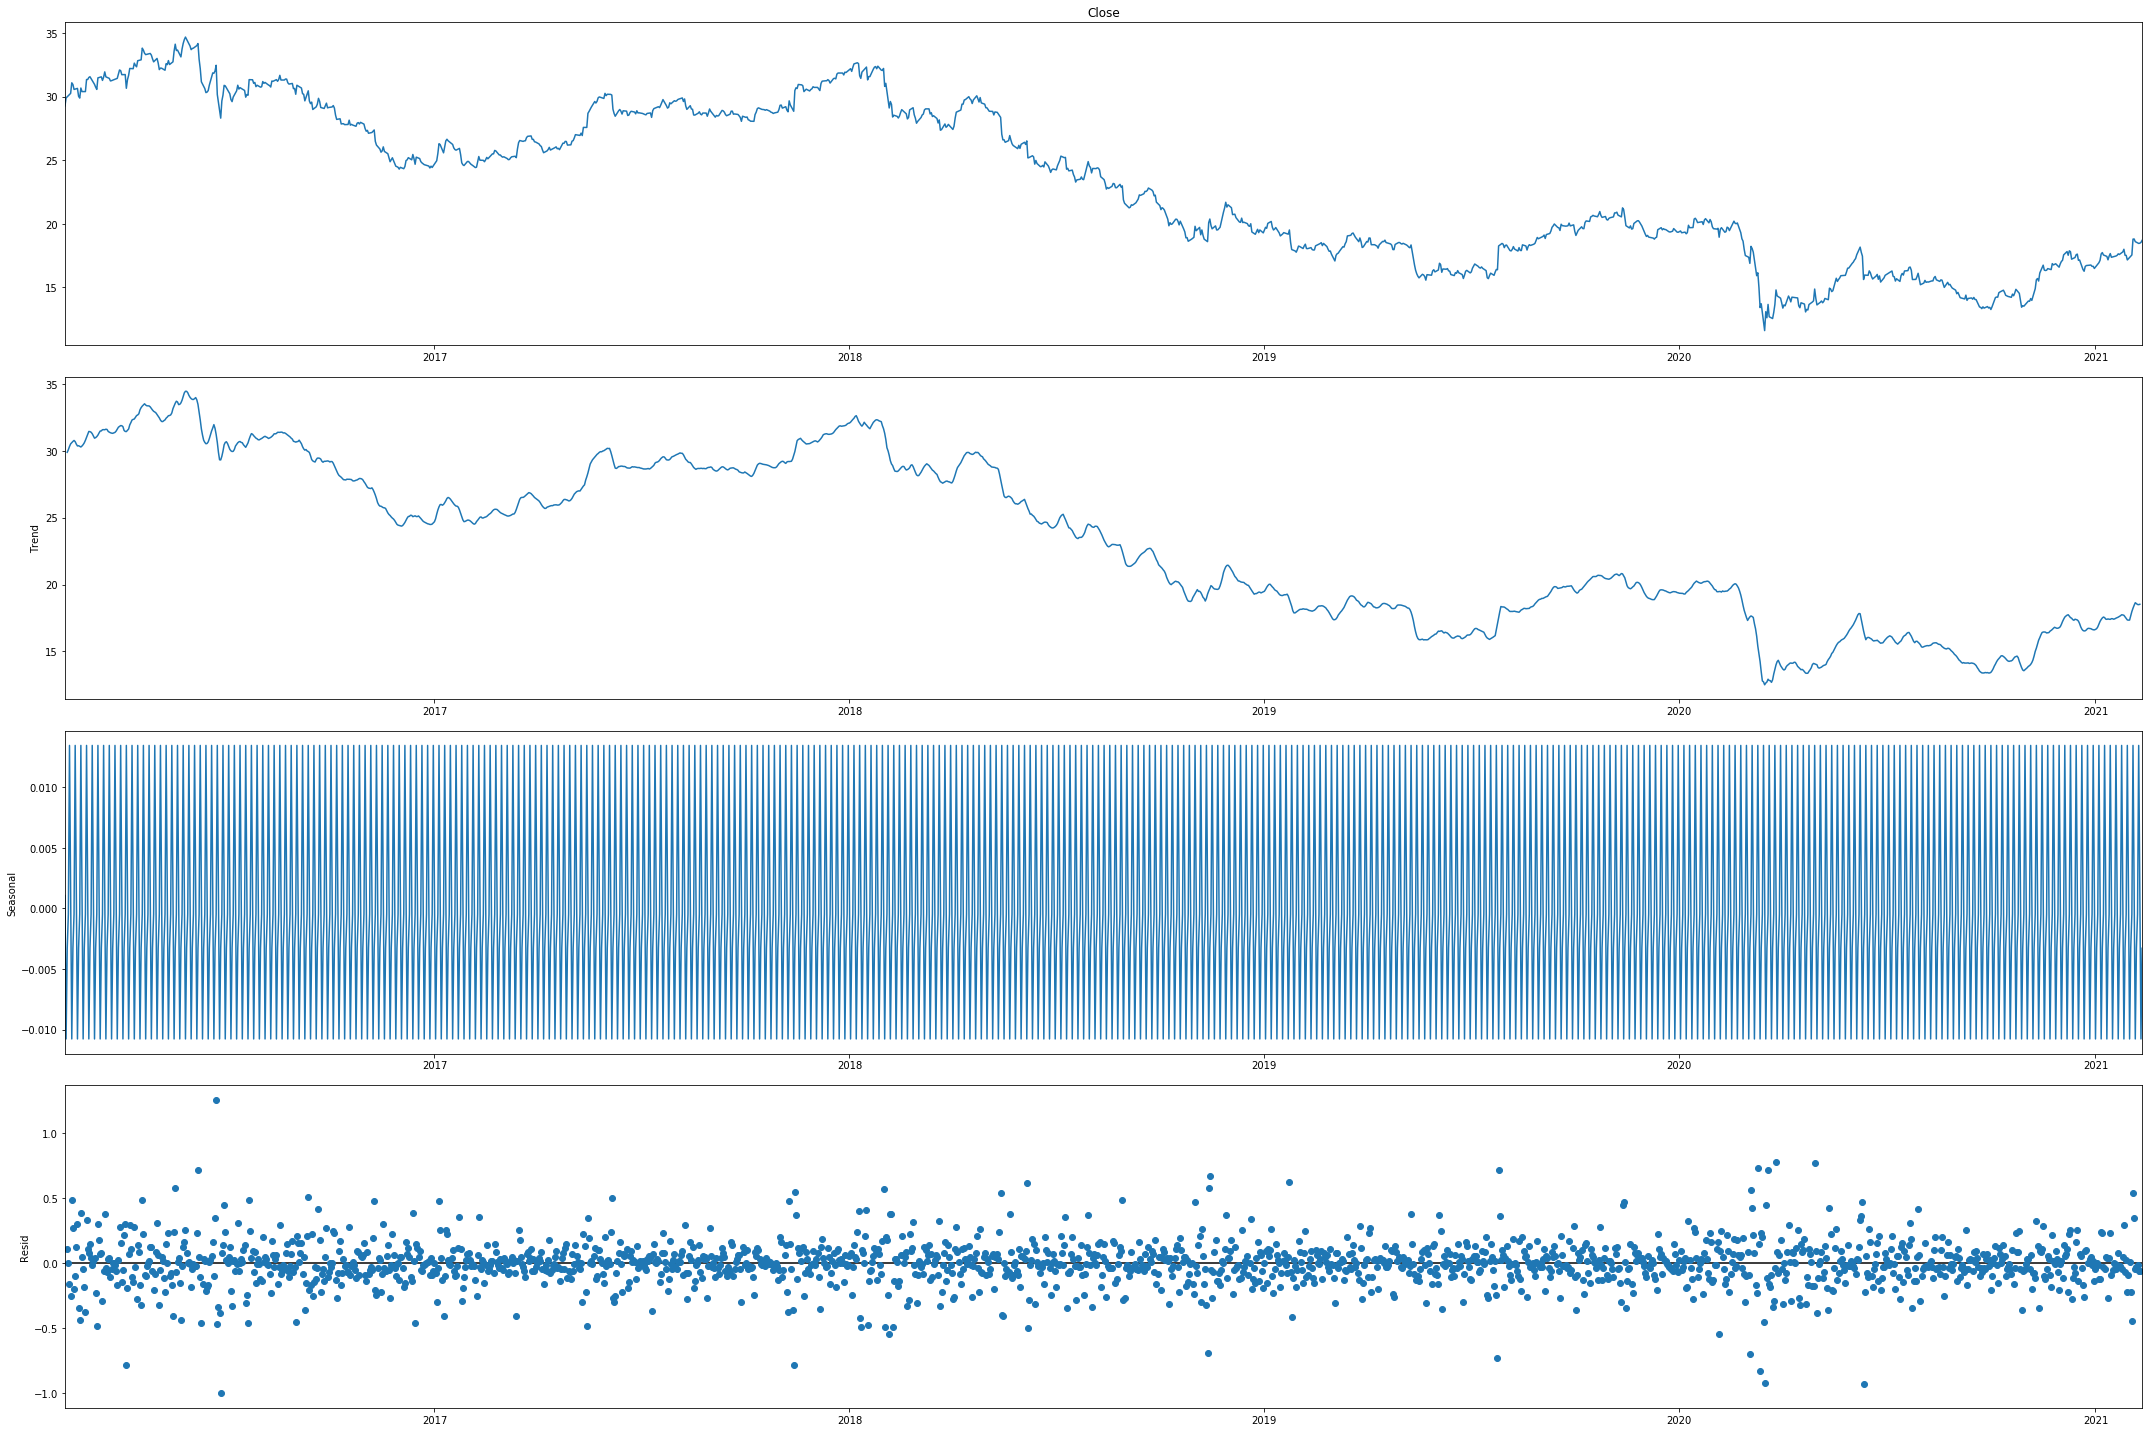

In [44]:
sesonal_decomposition_additive_5 = plot_decomposition(data_no_missing.Close, 'additive', 5)

##### Тест на стаціонарність для залишків

In [45]:
stationarity_test(sesonal_decomposition_additive_5.resid.dropna(), smt.adfuller)

{'adfuller_statistics': -15.827107274901538,
 'adfuller_p_value': 1.0043291380950204e-28,
 'adfuller_critical_values': {'1%': -3.4339840952648695,
  '5%': -2.8631452508003057,
  '10%': -2.567624583142913}}

In [46]:
stationarity_test(sesonal_decomposition_additive_5.resid.dropna(), smt.kpss)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


{'kpss_statistics': 0.011048183295121446,
 'kpss_p_value': 0.1,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Additive model

##### period=20

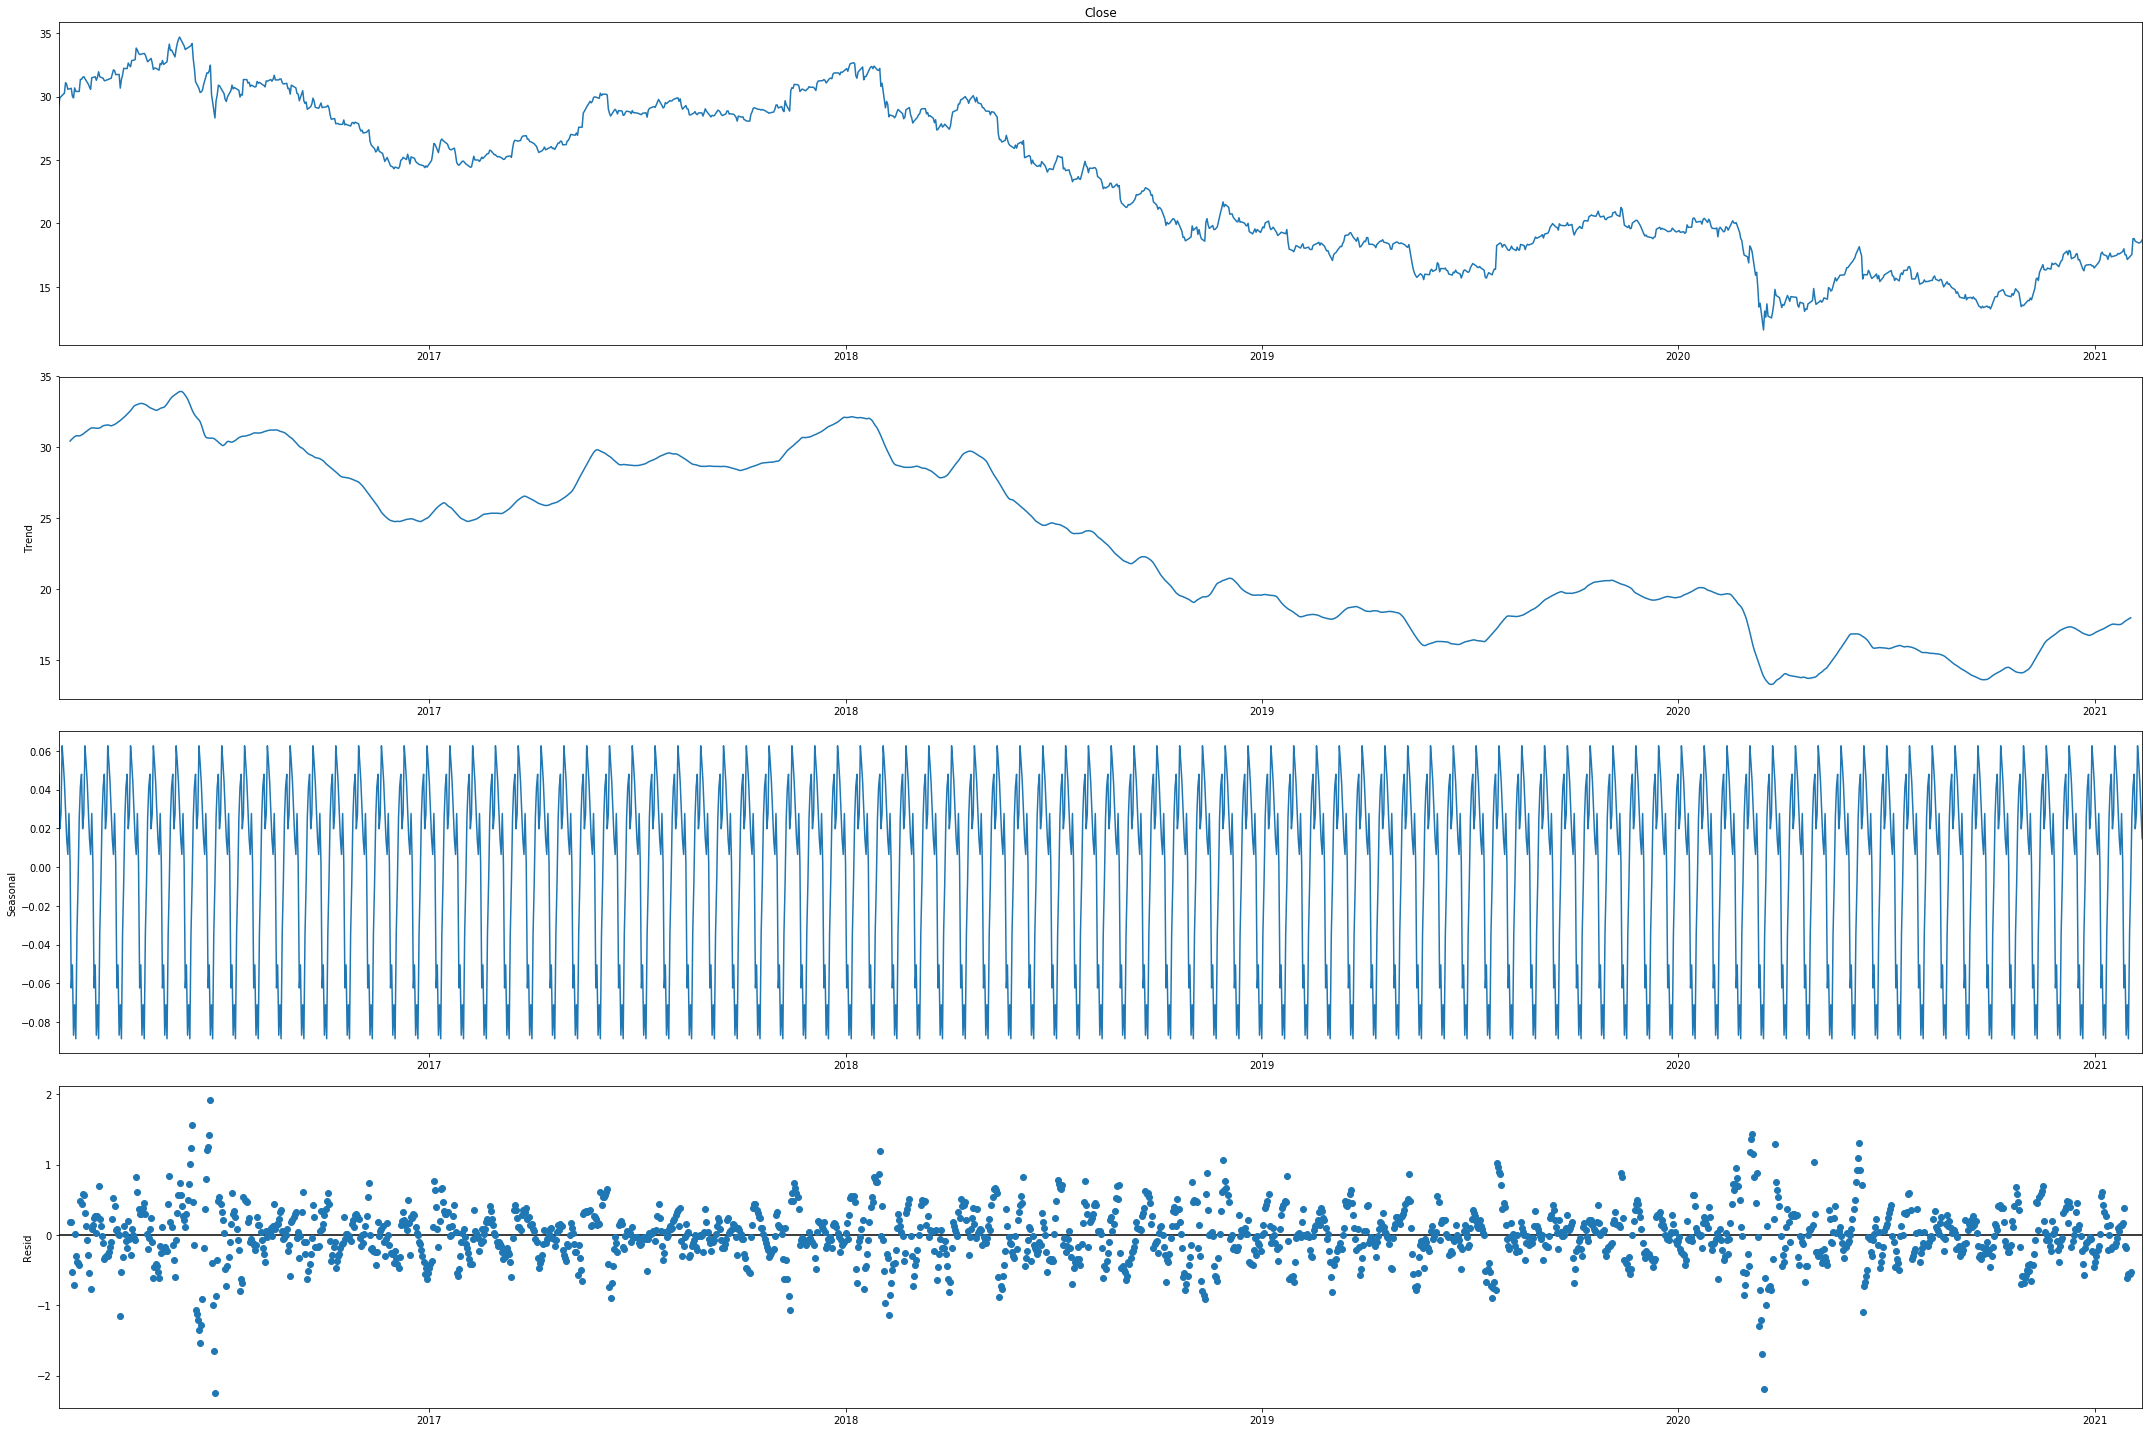

In [47]:
sesonal_decomposition_additive_20 = plot_decomposition(data_no_missing.Close, 'additive', 20)

##### Тест на стаціонарність для залишків

In [48]:
stationarity_test(sesonal_decomposition_additive_20.resid.dropna(), smt.adfuller)

{'adfuller_statistics': -12.927870360509399,
 'adfuller_p_value': 3.754426786446826e-24,
 'adfuller_critical_values': {'1%': -3.434022876868246,
  '5%': -2.8631623708604996,
  '10%': -2.5676336990659903}}

In [49]:
stationarity_test(sesonal_decomposition_additive_20.resid.dropna(), smt.kpss)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


{'kpss_statistics': 0.012725962247832527,
 'kpss_p_value': 0.1,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Additive model

##### period=253

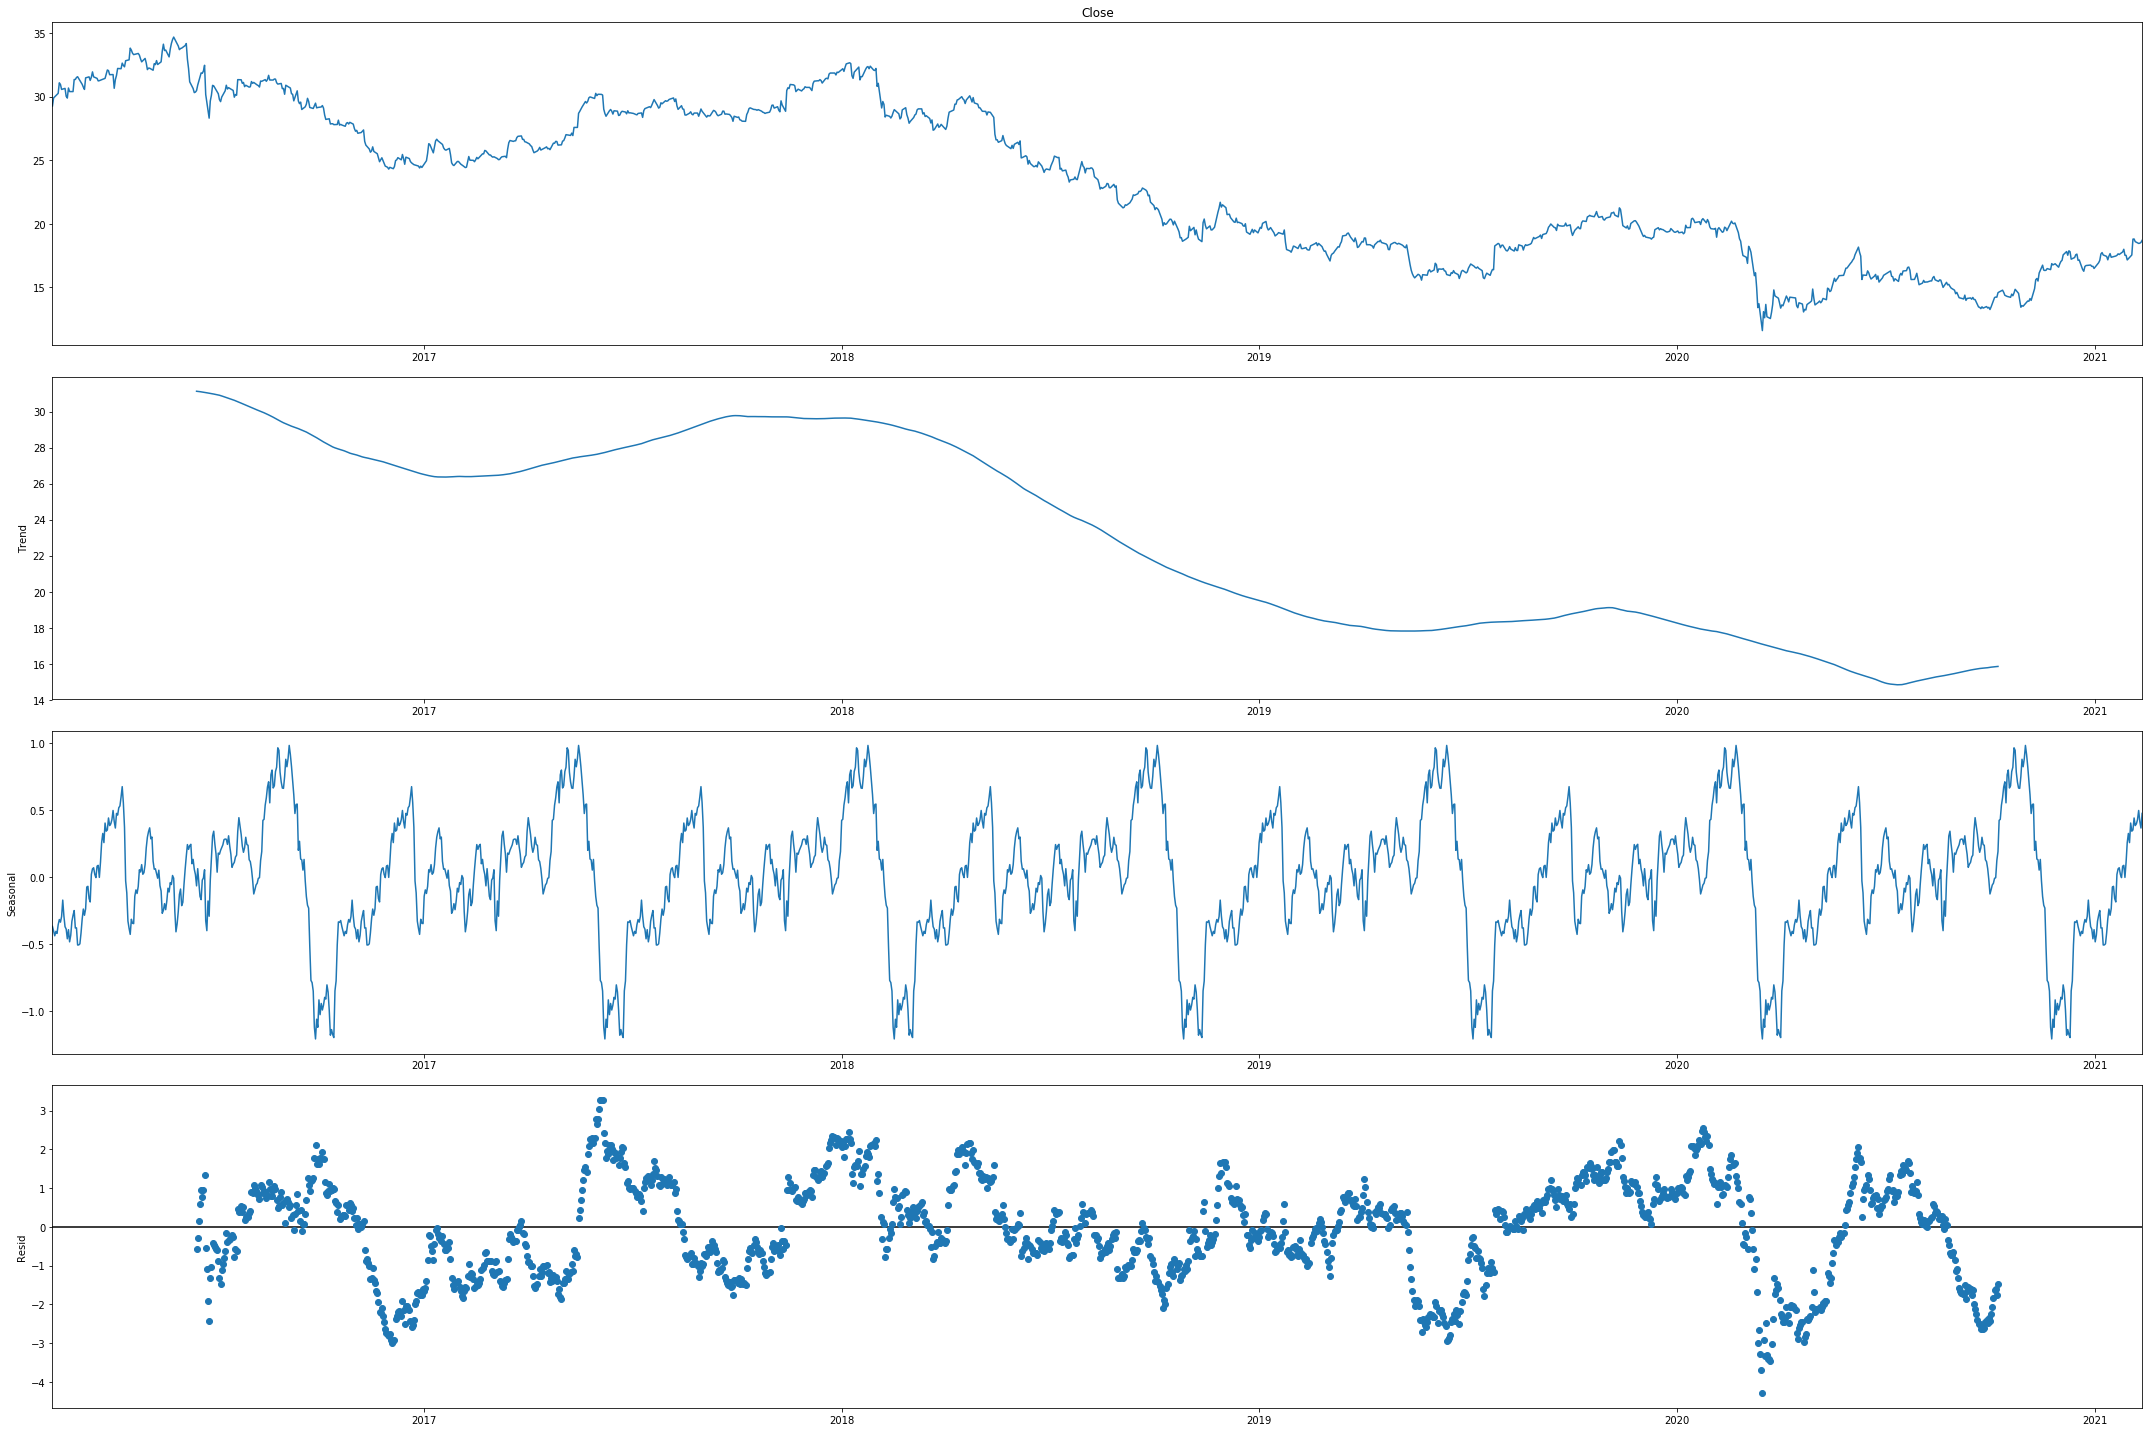

In [50]:
sesonal_decomposition_additive_253 = plot_decomposition(data_no_missing.Close, 'additive', 253)

##### Тест на стаціонарність для залишків

In [51]:
stationarity_test(sesonal_decomposition_additive_253.resid.dropna(), smt.adfuller)

{'adfuller_statistics': -4.317859037108563,
 'adfuller_p_value': 0.00041362143631278774,
 'adfuller_critical_values': {'1%': -3.4345140199818918,
  '5%': -2.8633791658322503,
  '10%': -2.567749139071643}}

In [52]:
stationarity_test(sesonal_decomposition_additive_253.resid.dropna(), smt.kpss)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


{'kpss_statistics': 0.09266132310912871,
 'kpss_p_value': 0.1,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Multiplicative model

##### period=5

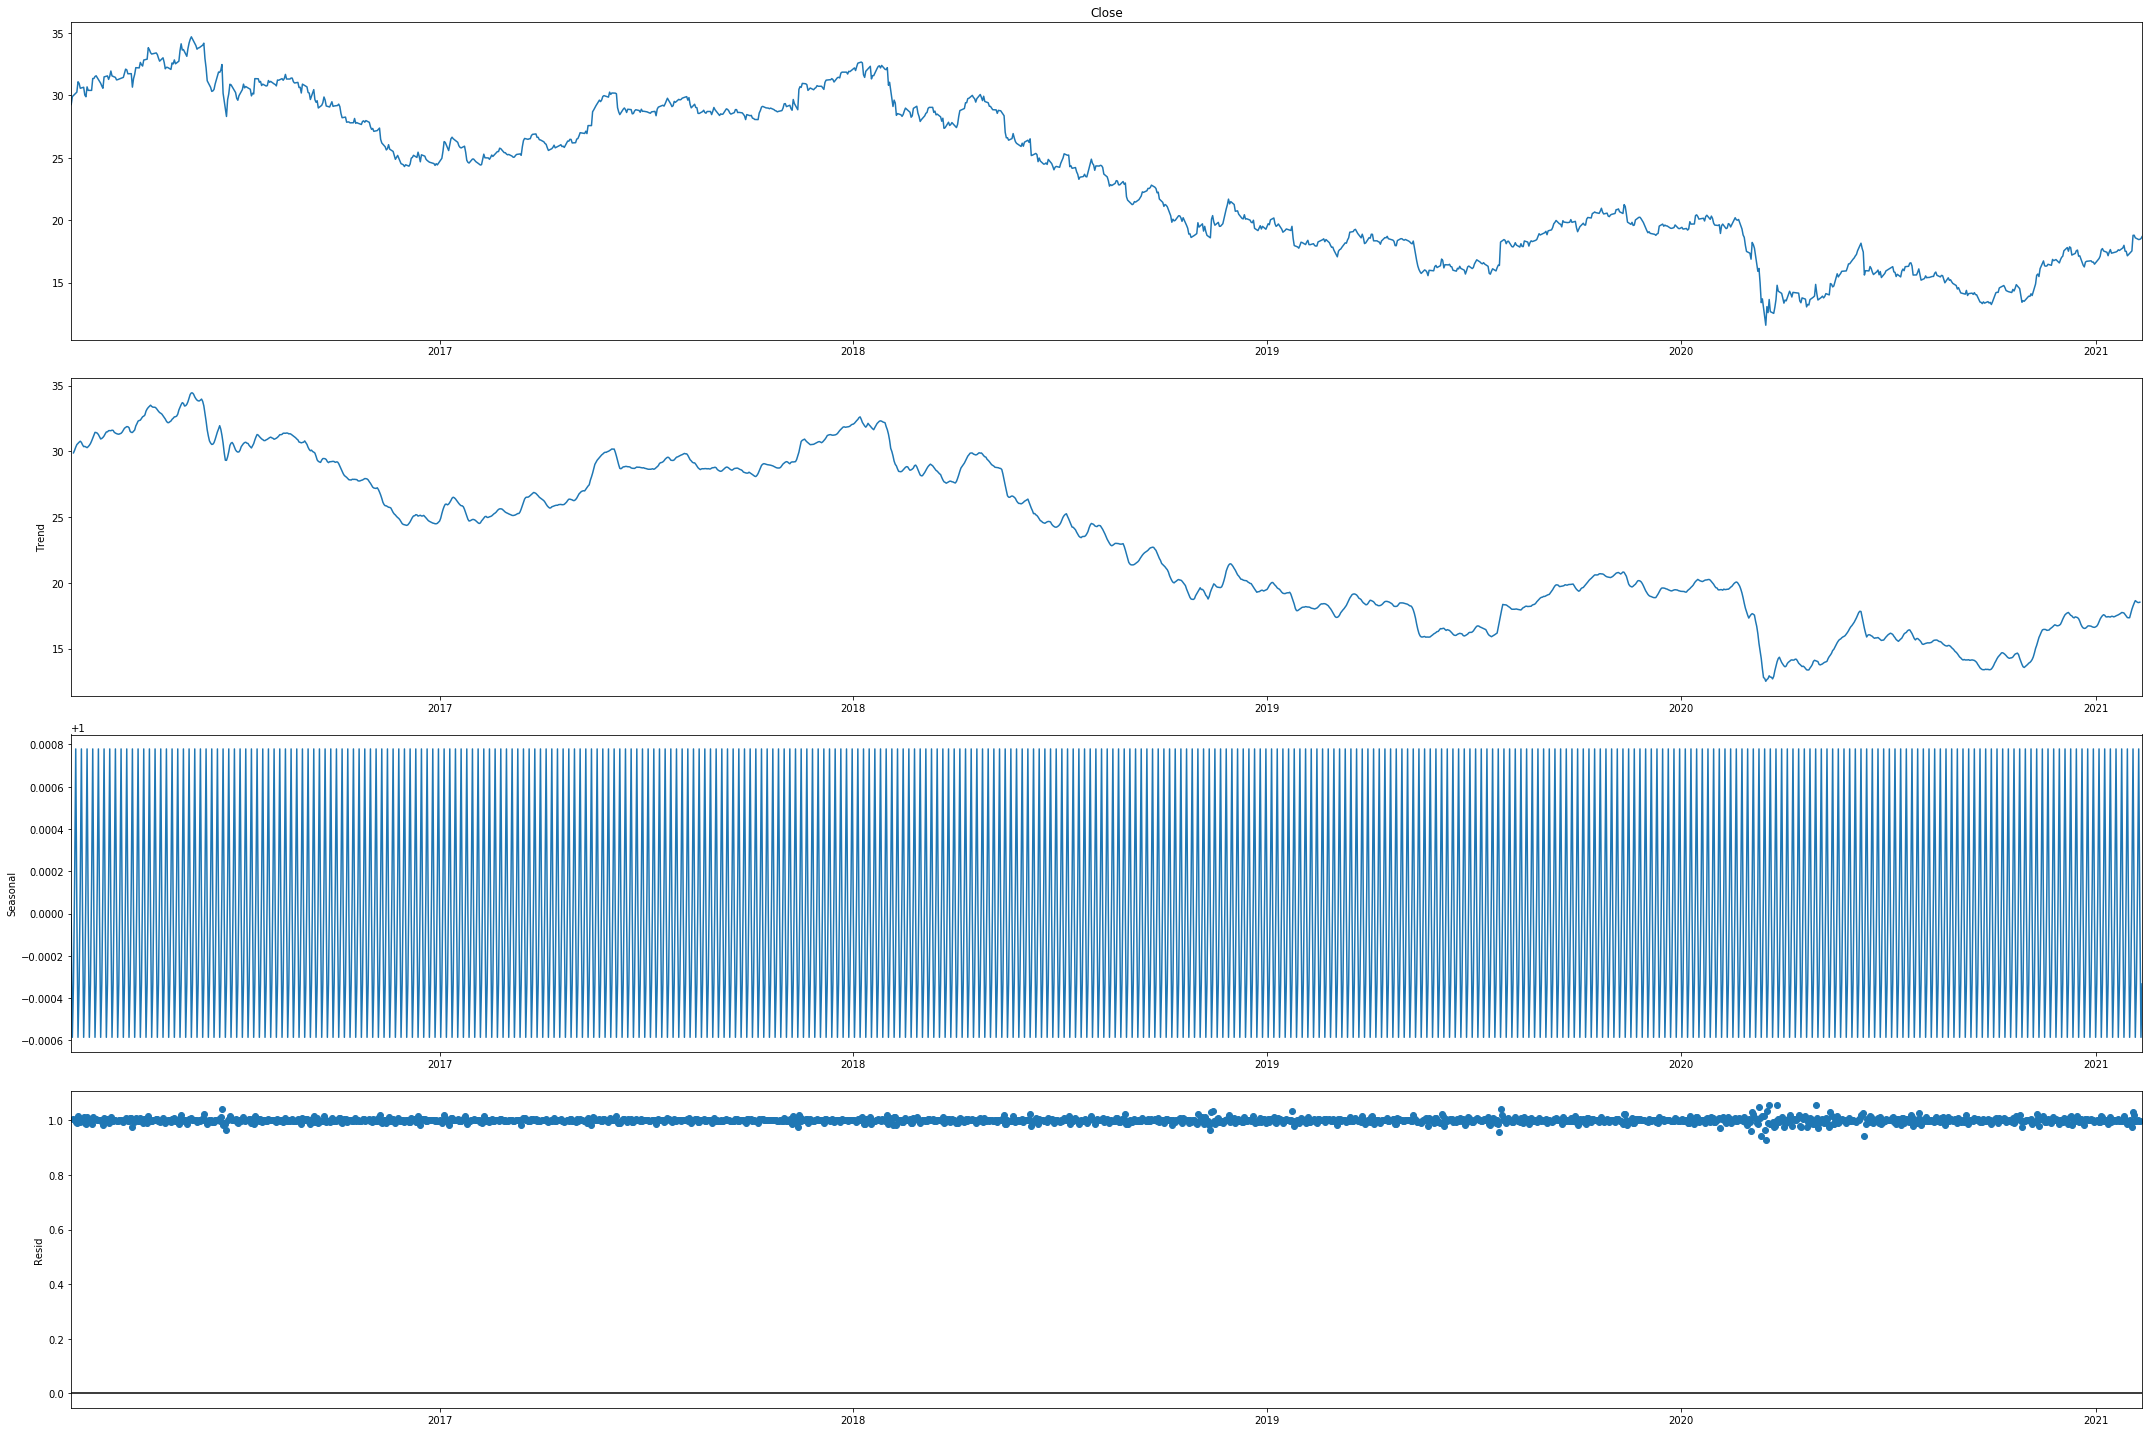

In [53]:
sesonal_decomposition_multiplicative_5 = plot_decomposition(data_no_missing.Close, 'multiplicative', 5)

##### Тест на стаціонарність для залишків

In [54]:
stationarity_test(sesonal_decomposition_multiplicative_5.resid.dropna(), smt.adfuller)

{'adfuller_statistics': -15.133115752251285,
 'adfuller_p_value': 7.184679279251661e-28,
 'adfuller_critical_values': {'1%': -3.4339840952648695,
  '5%': -2.8631452508003057,
  '10%': -2.567624583142913}}

In [55]:
stationarity_test(sesonal_decomposition_multiplicative_5.resid.dropna(), smt.kpss)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


{'kpss_statistics': 0.0327806199821291,
 'kpss_p_value': 0.1,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Multiplicative model

##### period=20

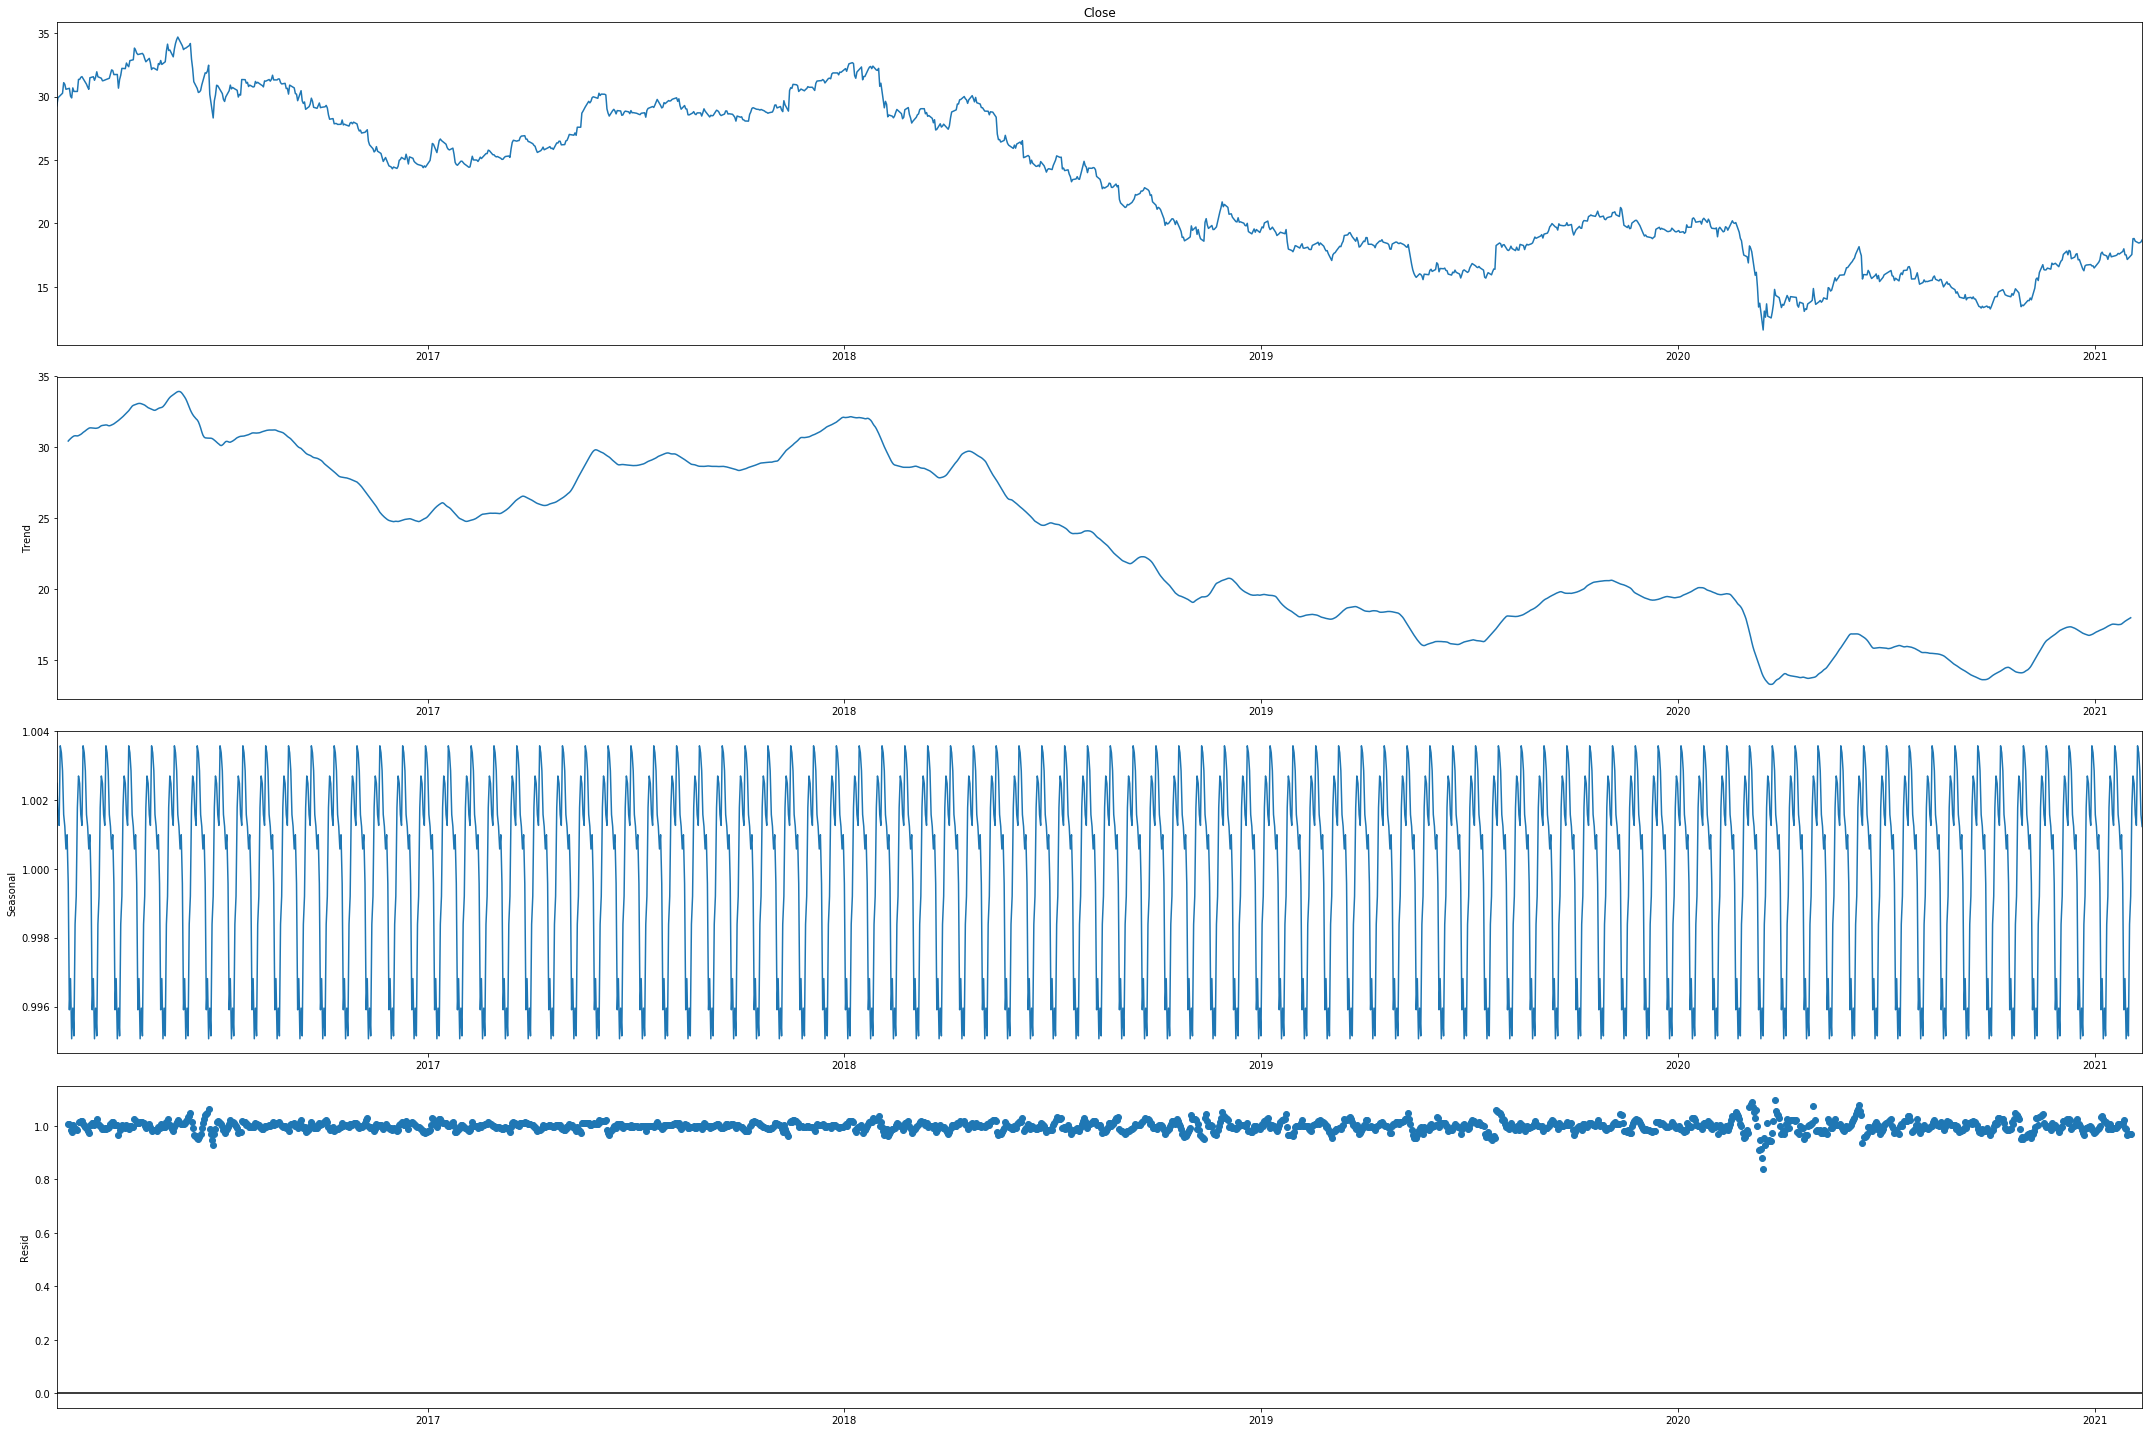

In [56]:
sesonal_decomposition_multiplicative_20 = plot_decomposition(data_no_missing.Close, 'multiplicative', 20)

##### Тест на стаціонарність для залишків

In [57]:
stationarity_test(sesonal_decomposition_multiplicative_20.resid.dropna(), smt.adfuller)

{'adfuller_statistics': -12.969482066859635,
 'adfuller_p_value': 3.102846019515092e-24,
 'adfuller_critical_values': {'1%': -3.4340249409468155,
  '5%': -2.8631632820375903,
  '10%': -2.5676341842417187}}

In [58]:
stationarity_test(sesonal_decomposition_multiplicative_20.resid.dropna(), smt.kpss)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


{'kpss_statistics': 0.029767313939176504,
 'kpss_p_value': 0.1,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Multiplicative model

##### period=253

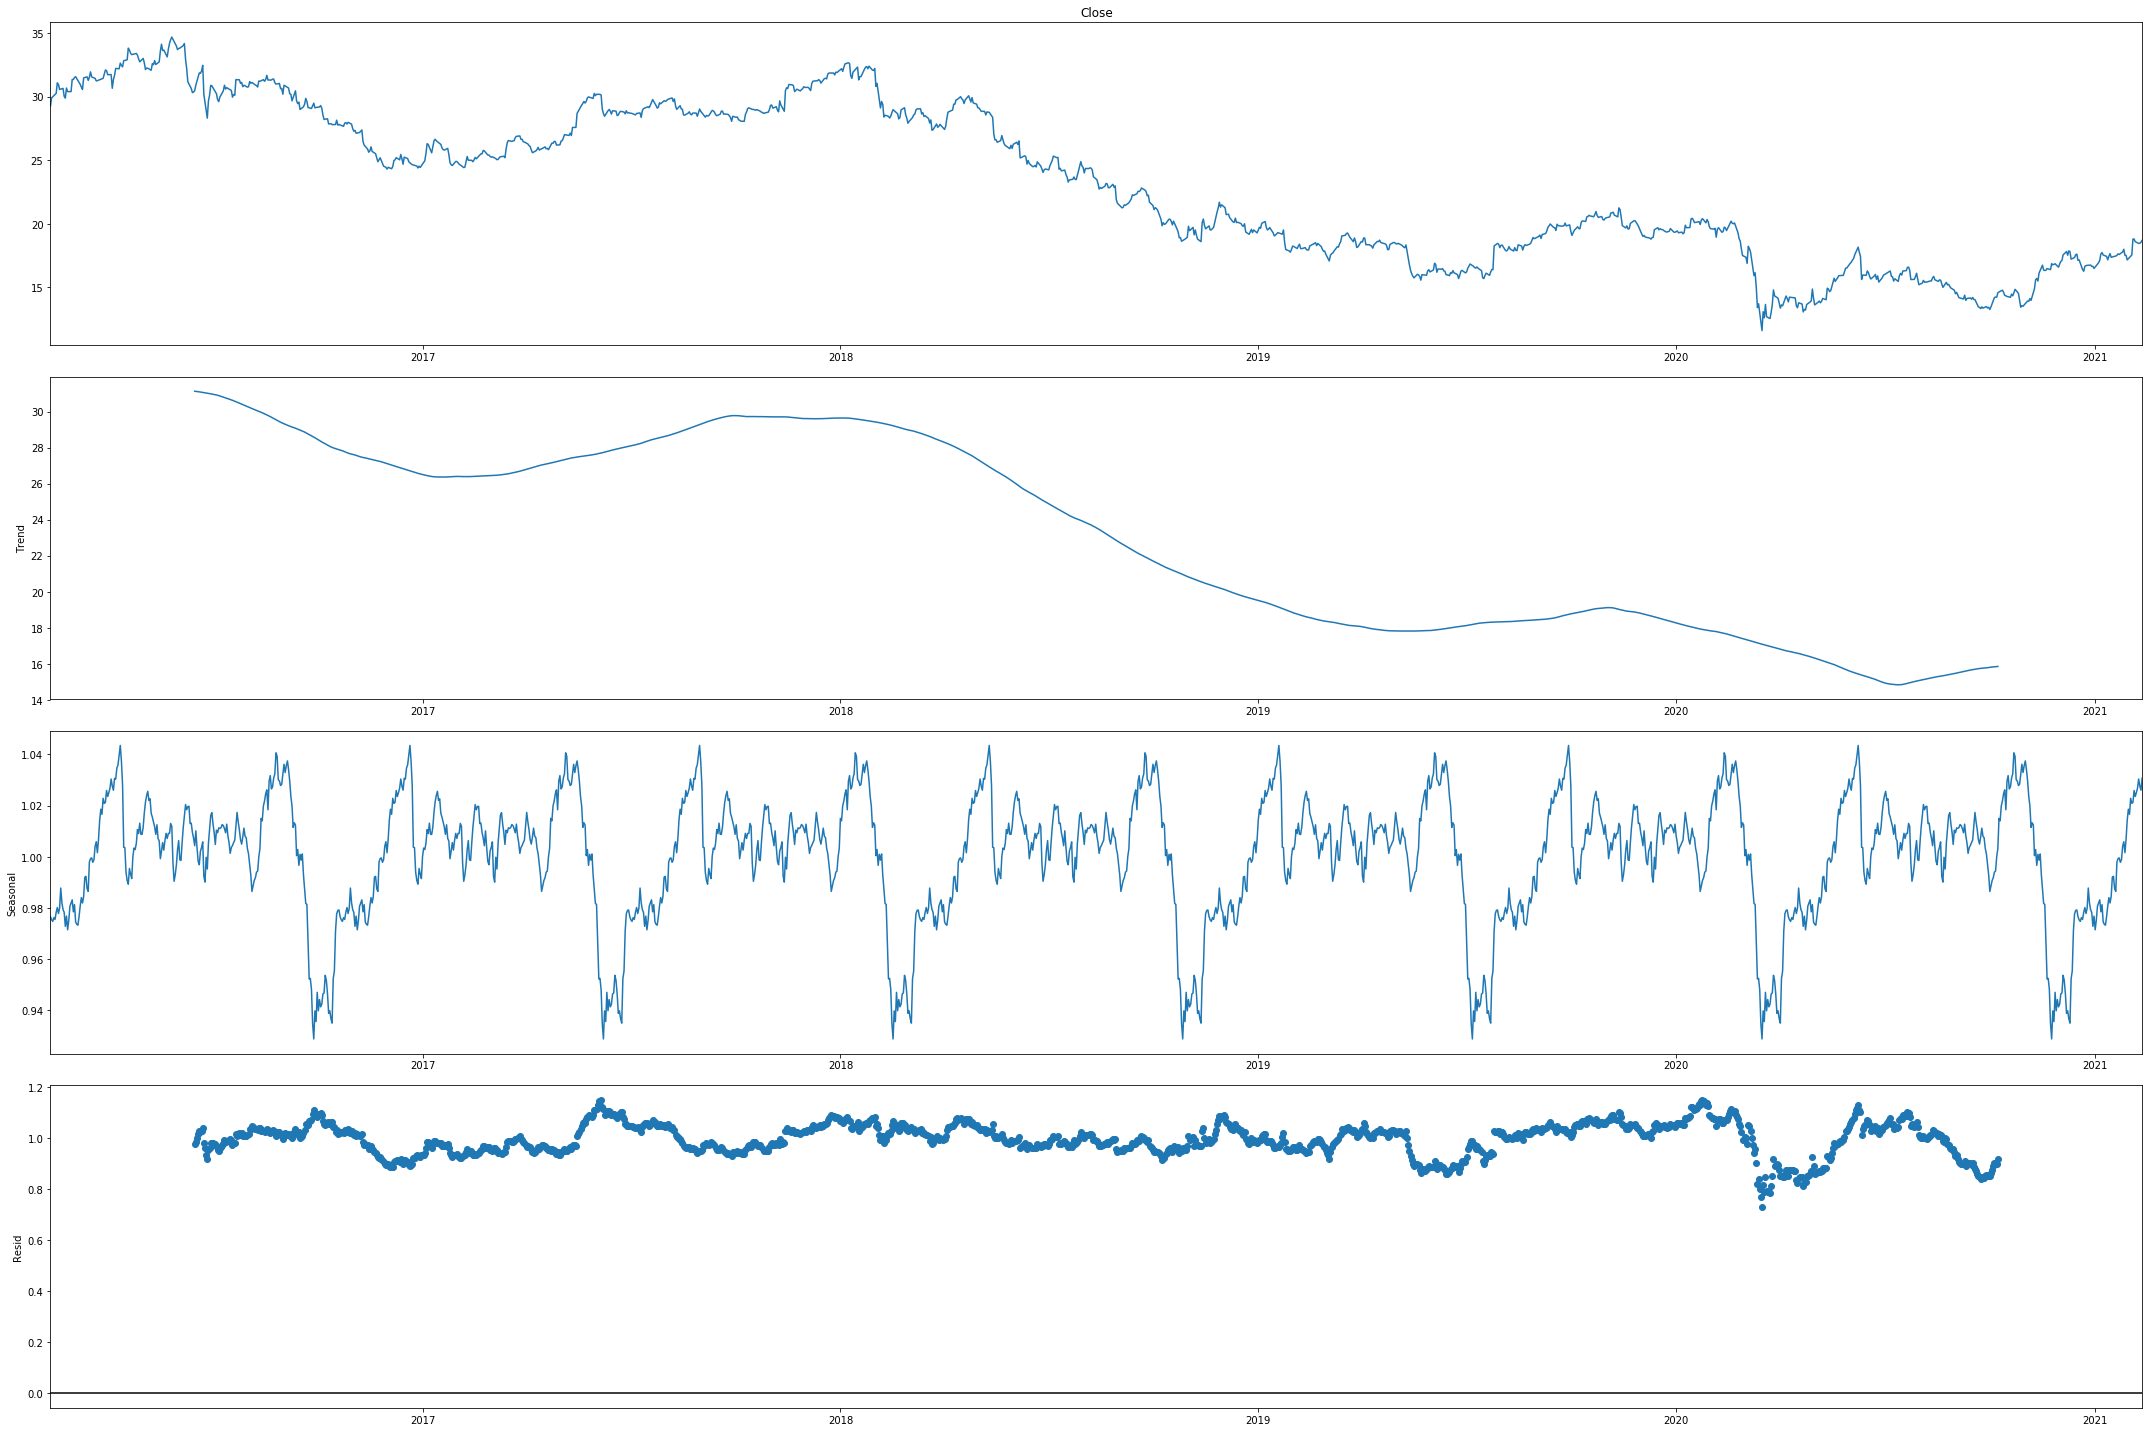

In [59]:
sesonal_decomposition_multiplicative_253 = plot_decomposition(data_no_missing.Close, 'multiplicative', 253)

##### Тест на стаціонарність для залишків

In [60]:
stationarity_test(sesonal_decomposition_multiplicative_253.resid.dropna(), smt.adfuller)

{'adfuller_statistics': -4.185755600115318,
 'adfuller_p_value': 0.0006964529735193253,
 'adfuller_critical_values': {'1%': -3.4345487774977768,
  '5%': -2.8633945067663817,
  '10%': -2.5677573081032214}}

In [61]:
stationarity_test(sesonal_decomposition_multiplicative_253.resid.dropna(), smt.kpss)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


{'kpss_statistics': 0.0968288059658316,
 'kpss_p_value': 0.1,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

## Побудова моделей за допомогою крос-валідації

In [62]:
data_no_missing = data_no_missing.reset_index(drop=False)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nla

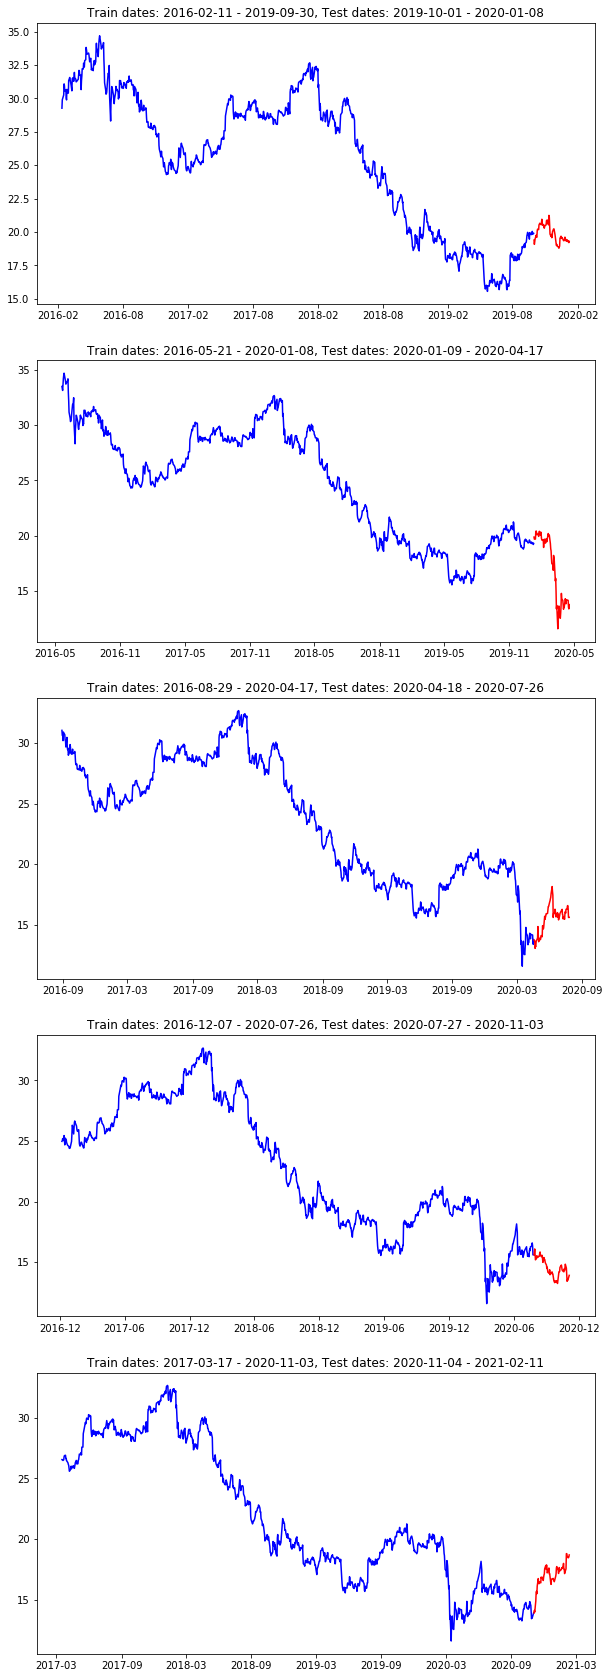

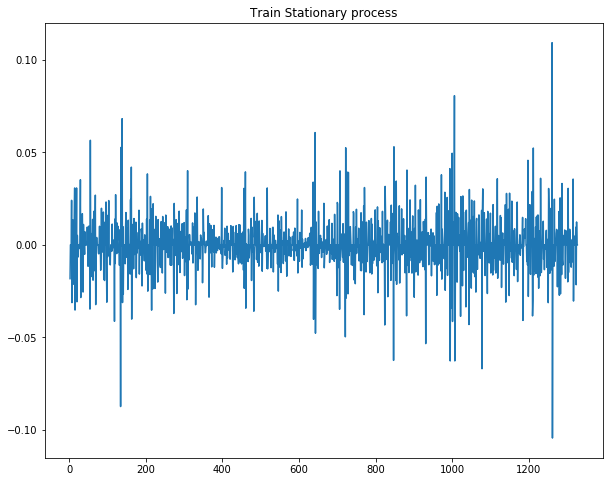

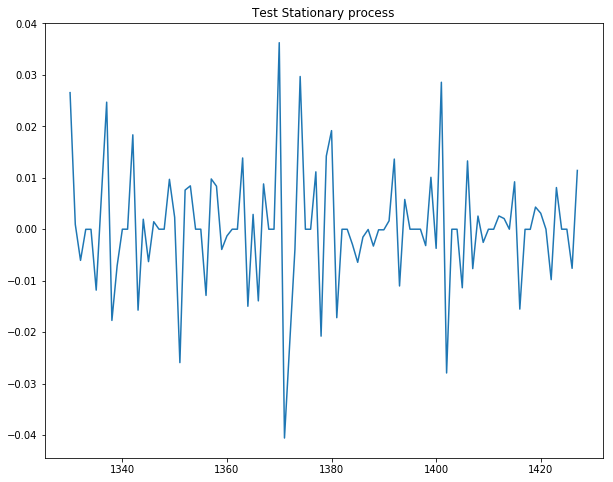

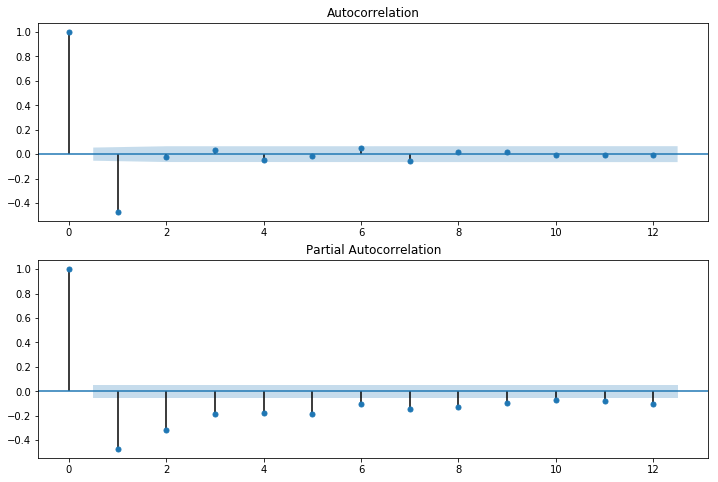

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was pro

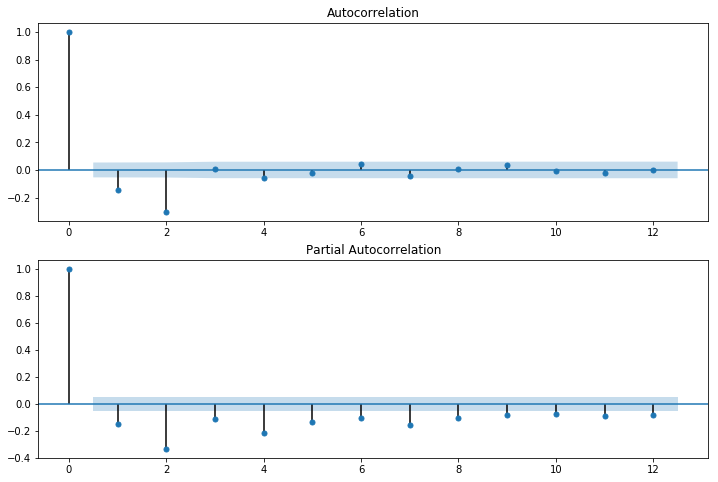

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


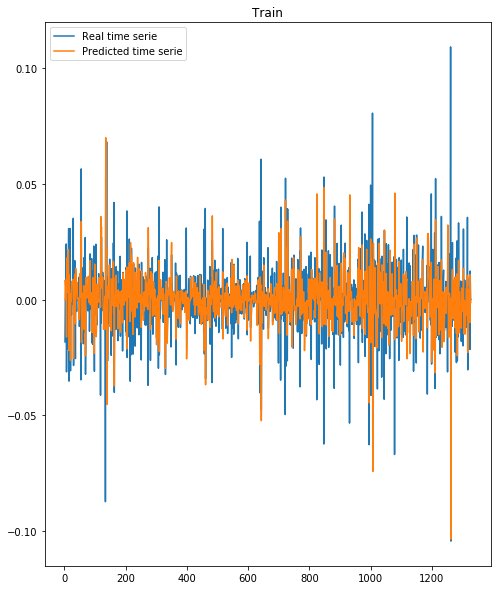

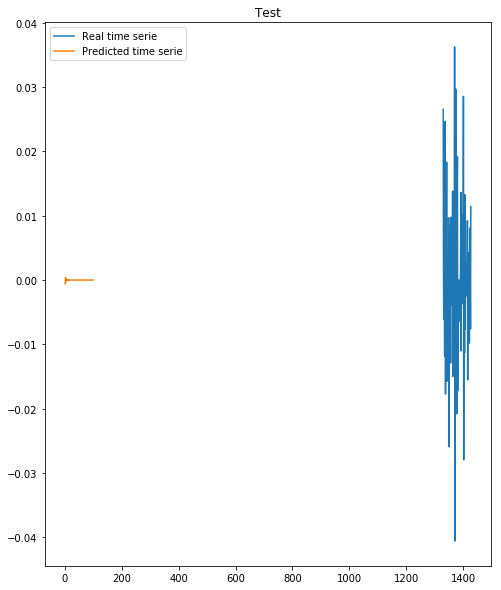

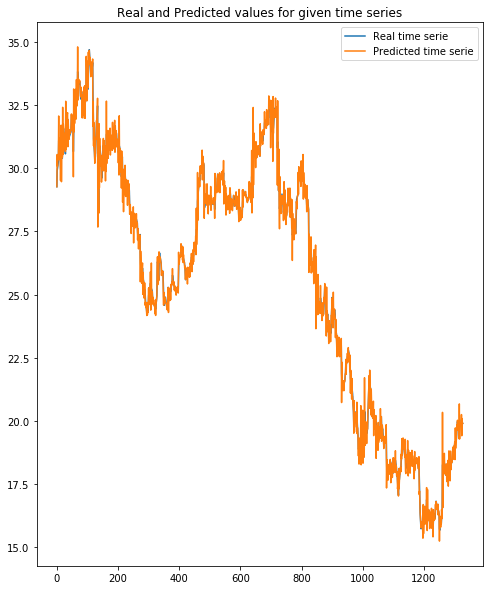

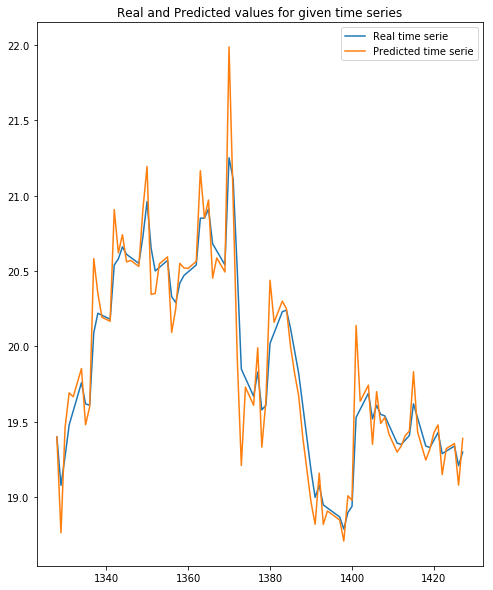

RMSE:     0.3597
RSS:   171.8650
MSE:     0.1294
MAE:     0.2186
MAPE:     0.0087
R2:     0.9950
RMSE:     0.1869
RSS:     3.4933
MSE:     0.0349
MAE:     0.1207
MAPE:     0.0060
R2:     0.9062


C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nla

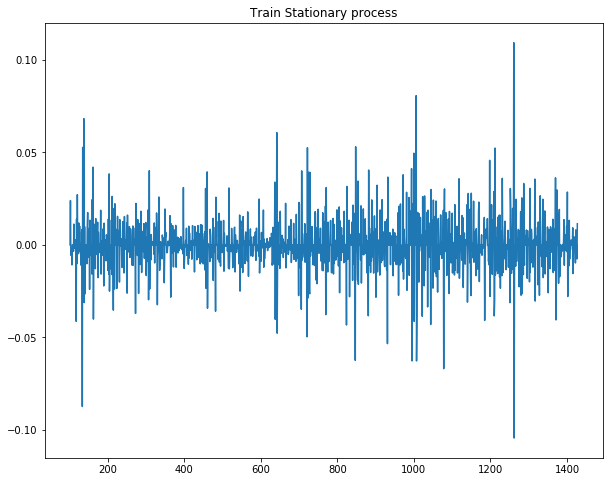

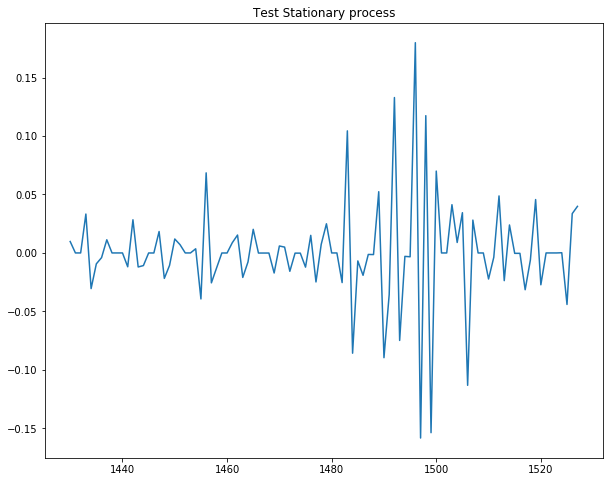

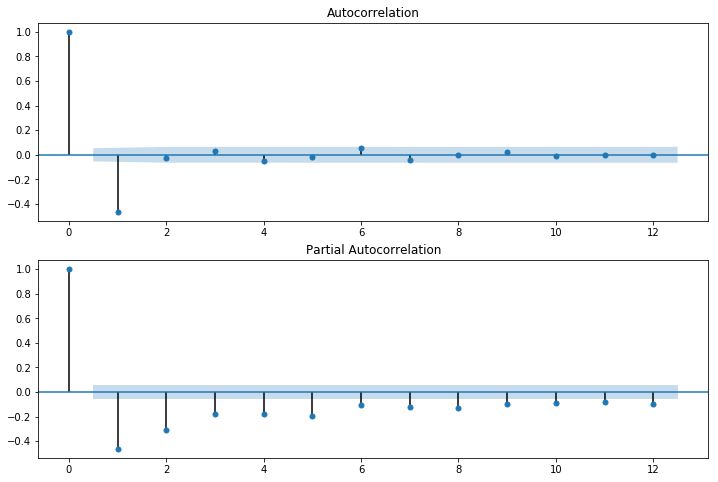

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was pro

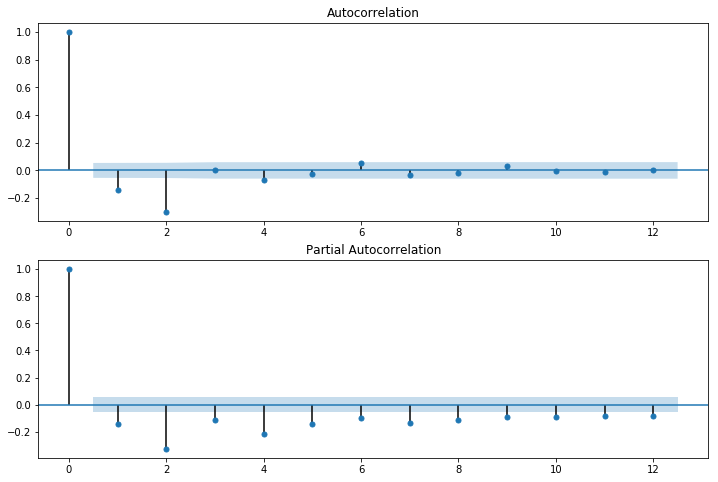

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


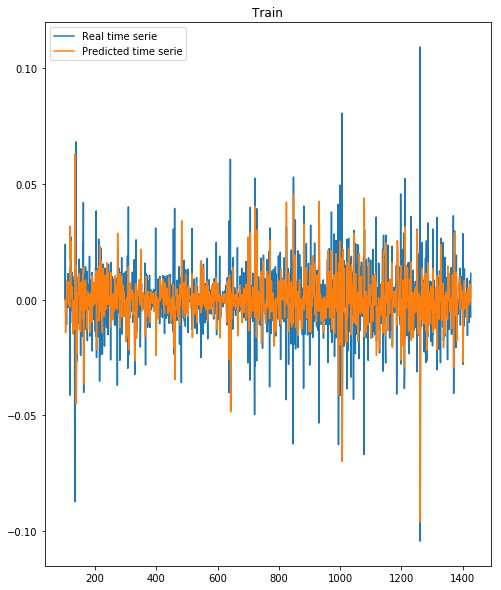

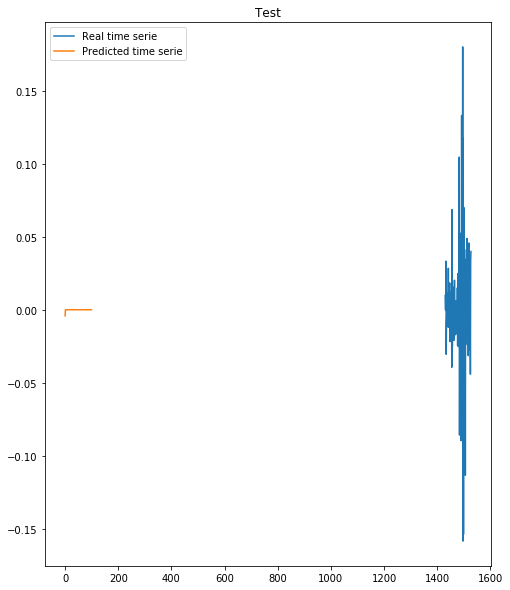

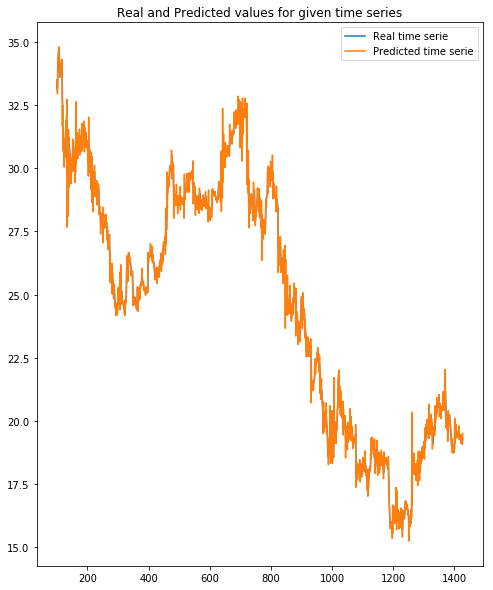

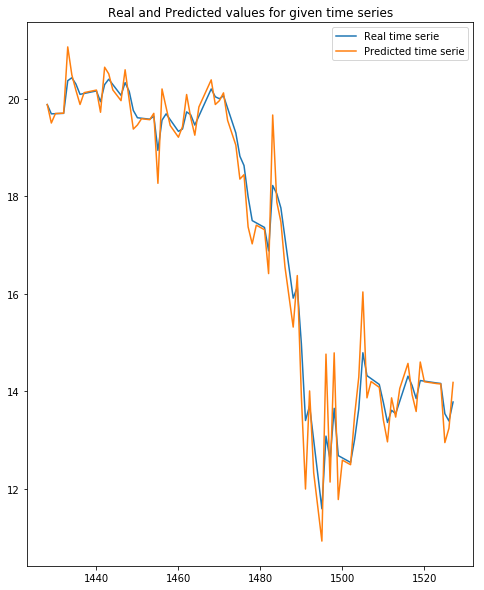

RMSE:     0.3297
RSS:   144.3600
MSE:     0.1087
MAE:     0.2000
MAPE:     0.0083
R2:     0.9956
RMSE:     0.4523
RSS:    20.4581
MSE:     0.2046
MAE:     0.2999
MAPE:     0.0194
R2:     0.9761


C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nla

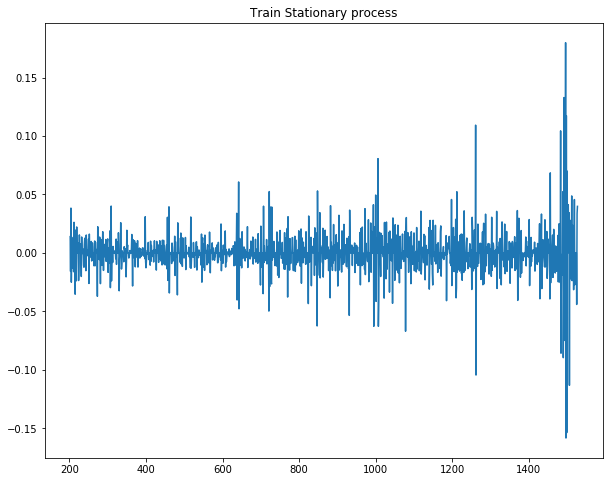

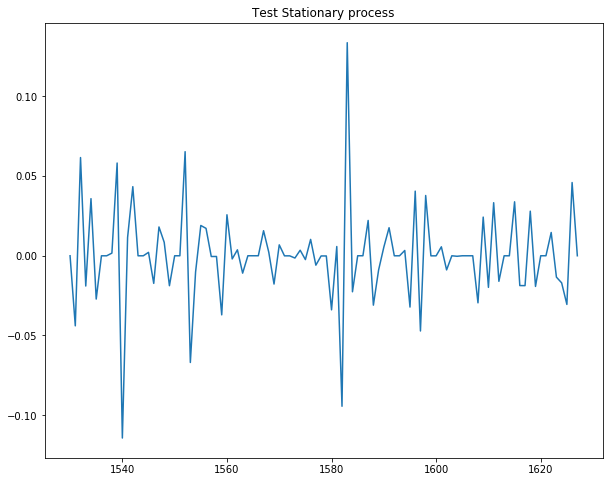

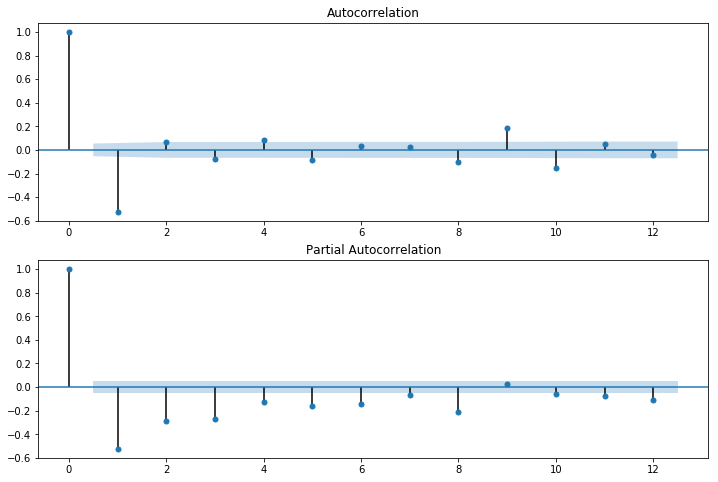

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was pro

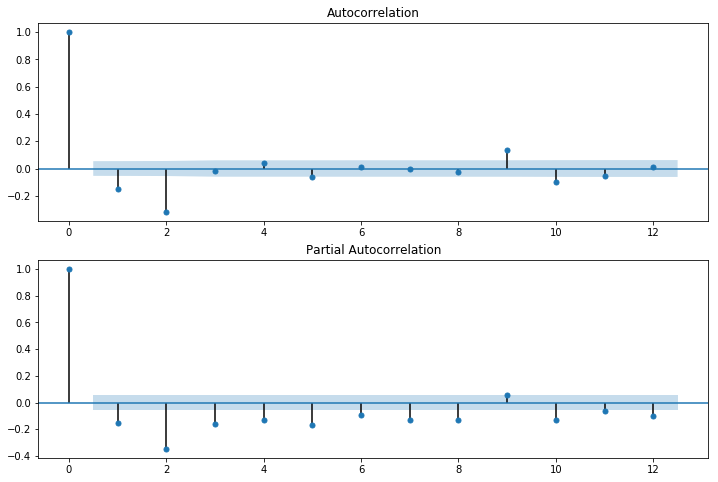

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


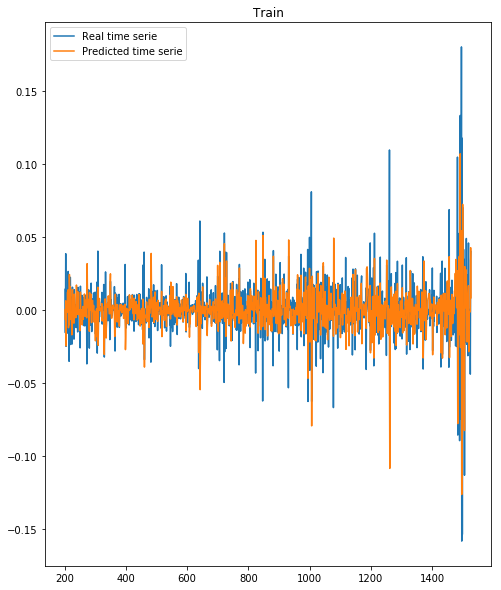

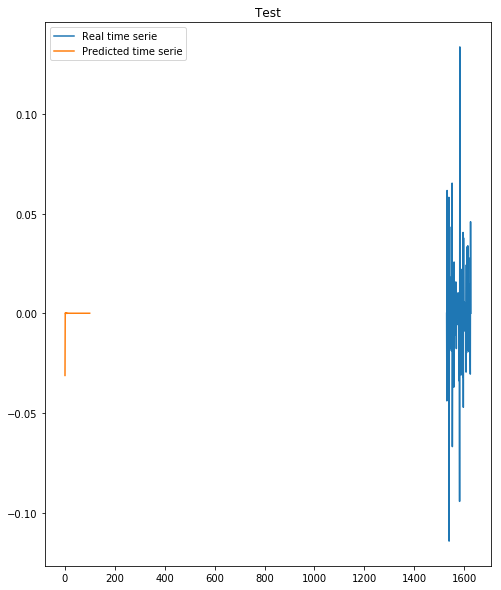

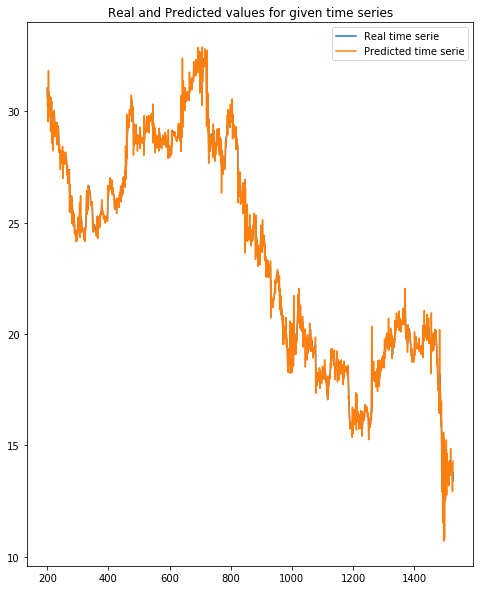

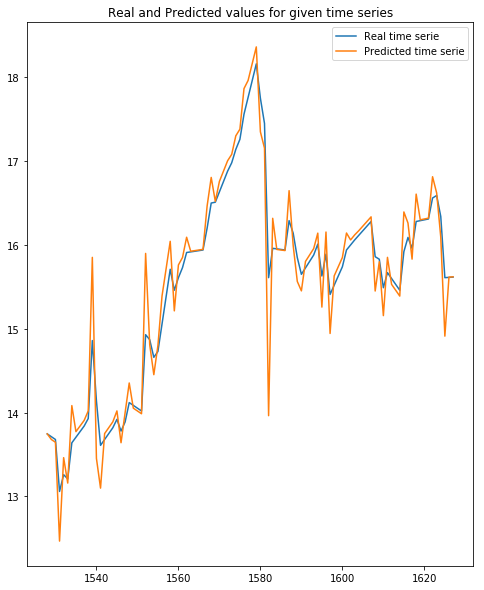

RMSE:     0.3655
RSS:   177.3608
MSE:     0.1336
MAE:     0.2190
MAPE:     0.0100
R2:     0.9947
RMSE:     0.3099
RSS:     9.6038
MSE:     0.0960
MAE:     0.1959
MAPE:     0.0127
R2:     0.9282


C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nla

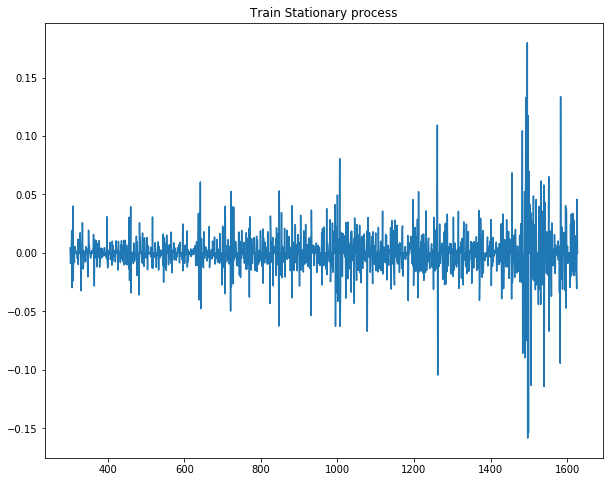

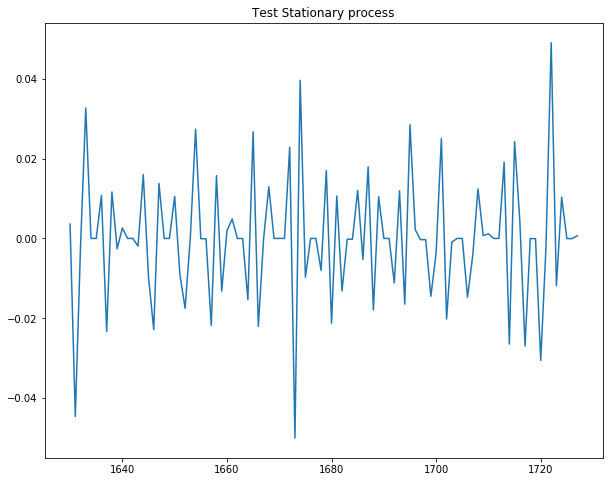

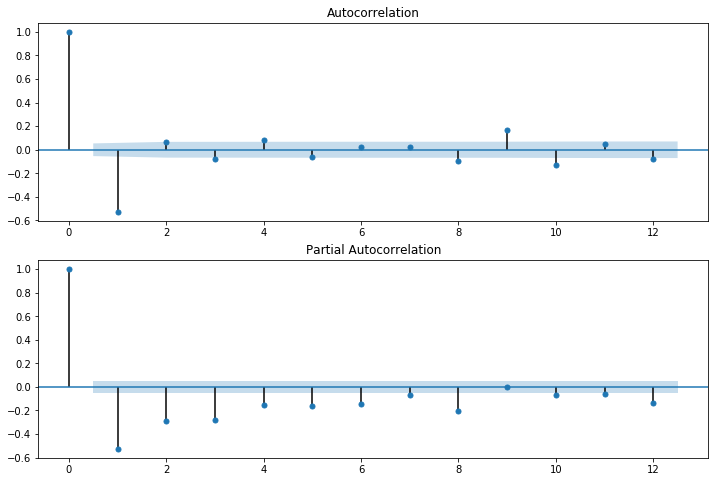

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was pro

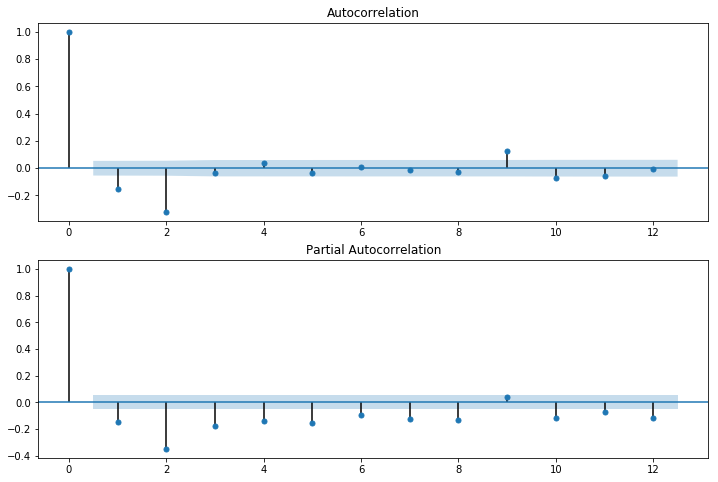

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


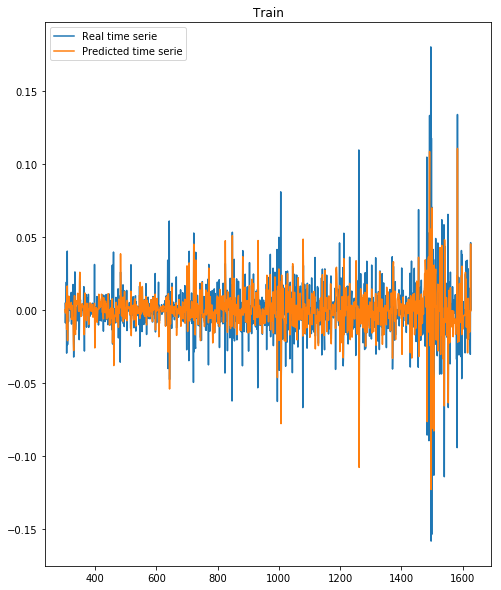

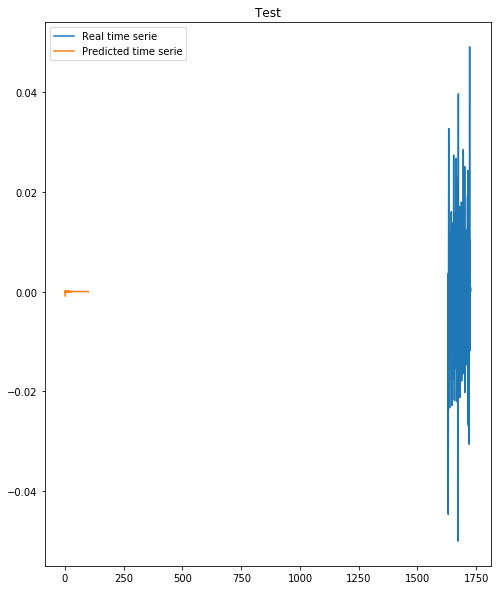

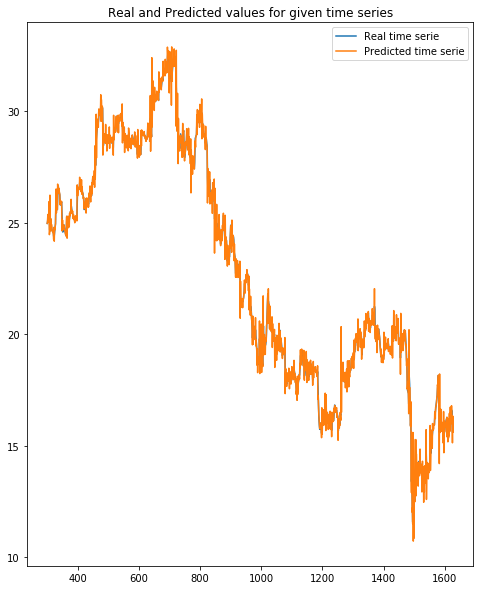

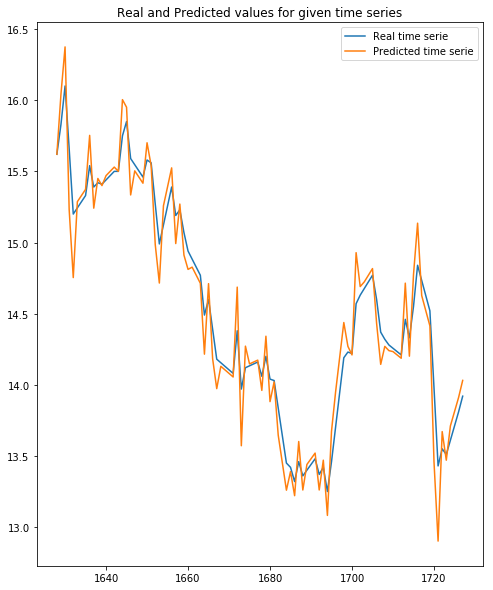

RMSE:     0.3719
RSS:   183.6811
MSE:     0.1383
MAE:     0.2185
MAPE:     0.0106
R2:     0.9950
RMSE:     0.1750
RSS:     3.0633
MSE:     0.0306
MAE:     0.1308
MAPE:     0.0090
R2:     0.9455


C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nla

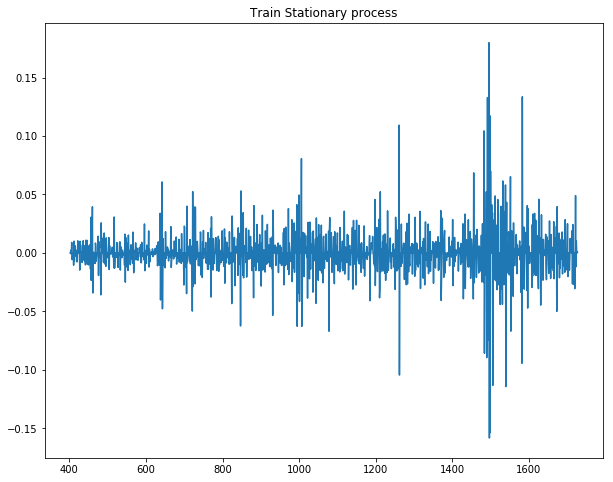

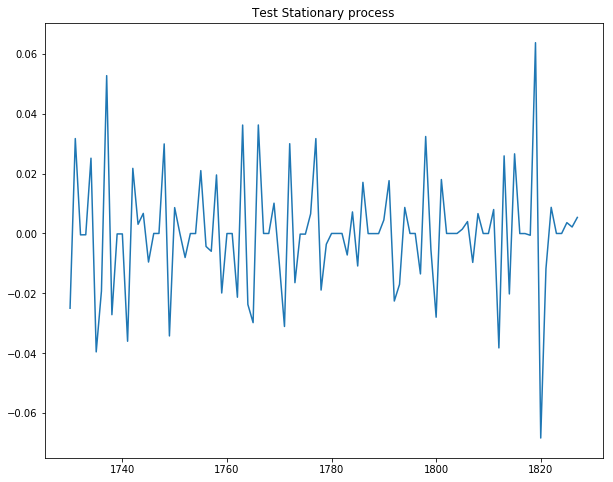

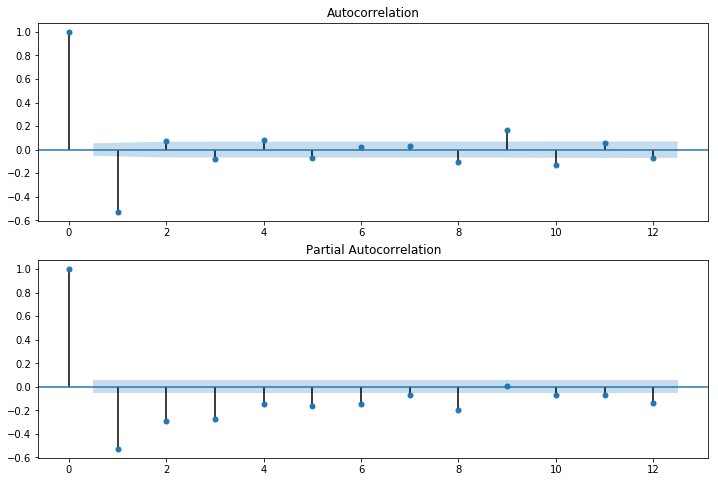

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was pro

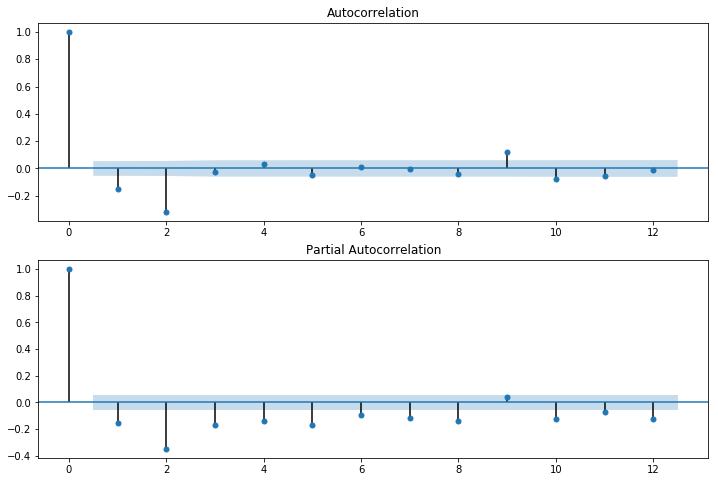

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


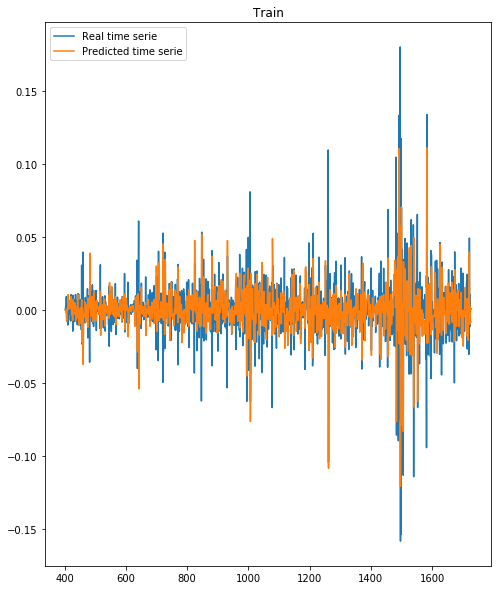

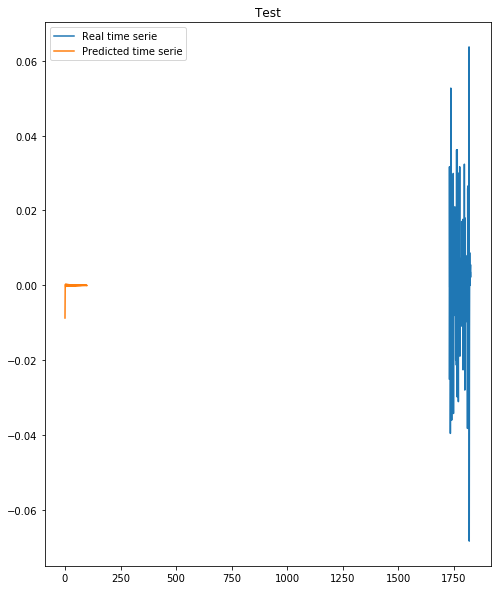

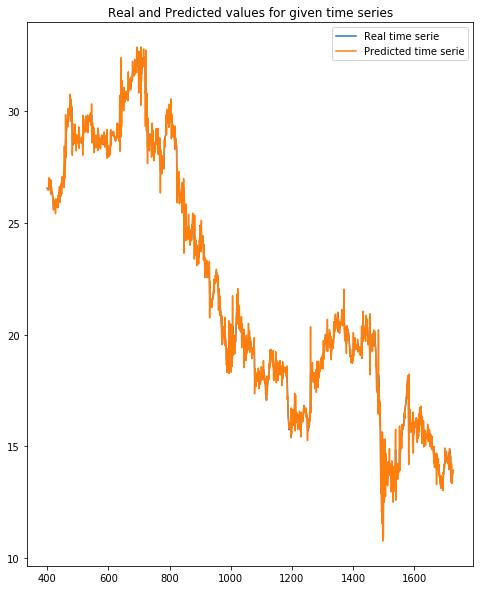

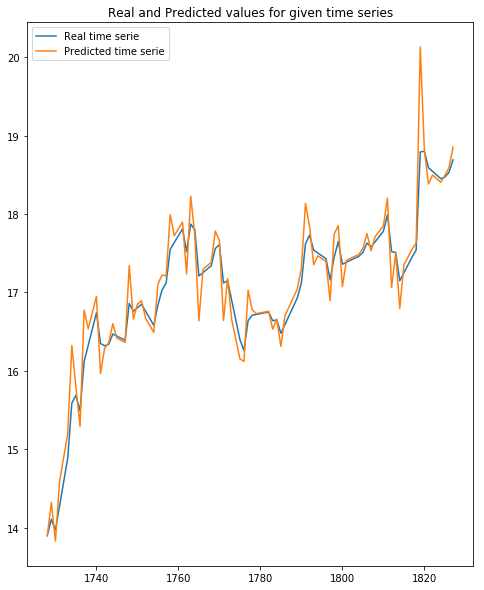

RMSE:     0.3713
RSS:   183.0715
MSE:     0.1379
MAE:     0.2180
MAPE:     0.0109
R2:     0.9956
RMSE:     0.2551
RSS:     6.5094
MSE:     0.0651
MAE:     0.1680
MAPE:     0.0099
R2:     0.9304


In [63]:
all_metrics_df, all_metrics_df_test = make_cross_validation(data_no_missing, test_size=100)

In [64]:
all_metrics_df

RMSE         RSS       MSE       MAE      MAPE  \
Cross-val iteration                                                       
0                    0.359745  171.864995  0.129416  0.218573  0.008730   
1                    0.329704  144.359971  0.108705  0.199998  0.008294   
2                    0.365452  177.360841  0.133555  0.219047  0.009992   
3                    0.371906  183.681149  0.138314  0.218463  0.010560   
4                    0.371288  183.071465  0.137855  0.218030  0.010885   

                           R2  durbin_watson  
Cross-val iteration                           
0                    0.995028       1.907005  
1                    0.995608       2.009130  
2                    0.994672       1.929049  
3                    0.995004       1.968321  
4                    0.995640       1.968254

In [65]:
all_metrics_df_test

RMSE        RSS       MSE       MAE      MAPE  \
Cross-val iteration                                                      
0                    0.186904   3.493324  0.034933  0.120744  0.006046   
1                    0.452306  20.458108  0.204581  0.299875  0.019375   
2                    0.309901   9.603844  0.096038  0.195896  0.012715   
3                    0.175023   3.063294  0.030633  0.130778  0.009028   
4                    0.255136   6.509438  0.065094  0.167960  0.009936   

                           R2  durbin_watson  
Cross-val iteration                           
0                    0.906160       1.907005  
1                    0.976064       2.009130  
2                    0.928230       1.929049  
3                    0.945540       1.968321  
4                    0.930437       1.968254

### Розподіл метрик по ітераціям

#### Тренувальні вибірки

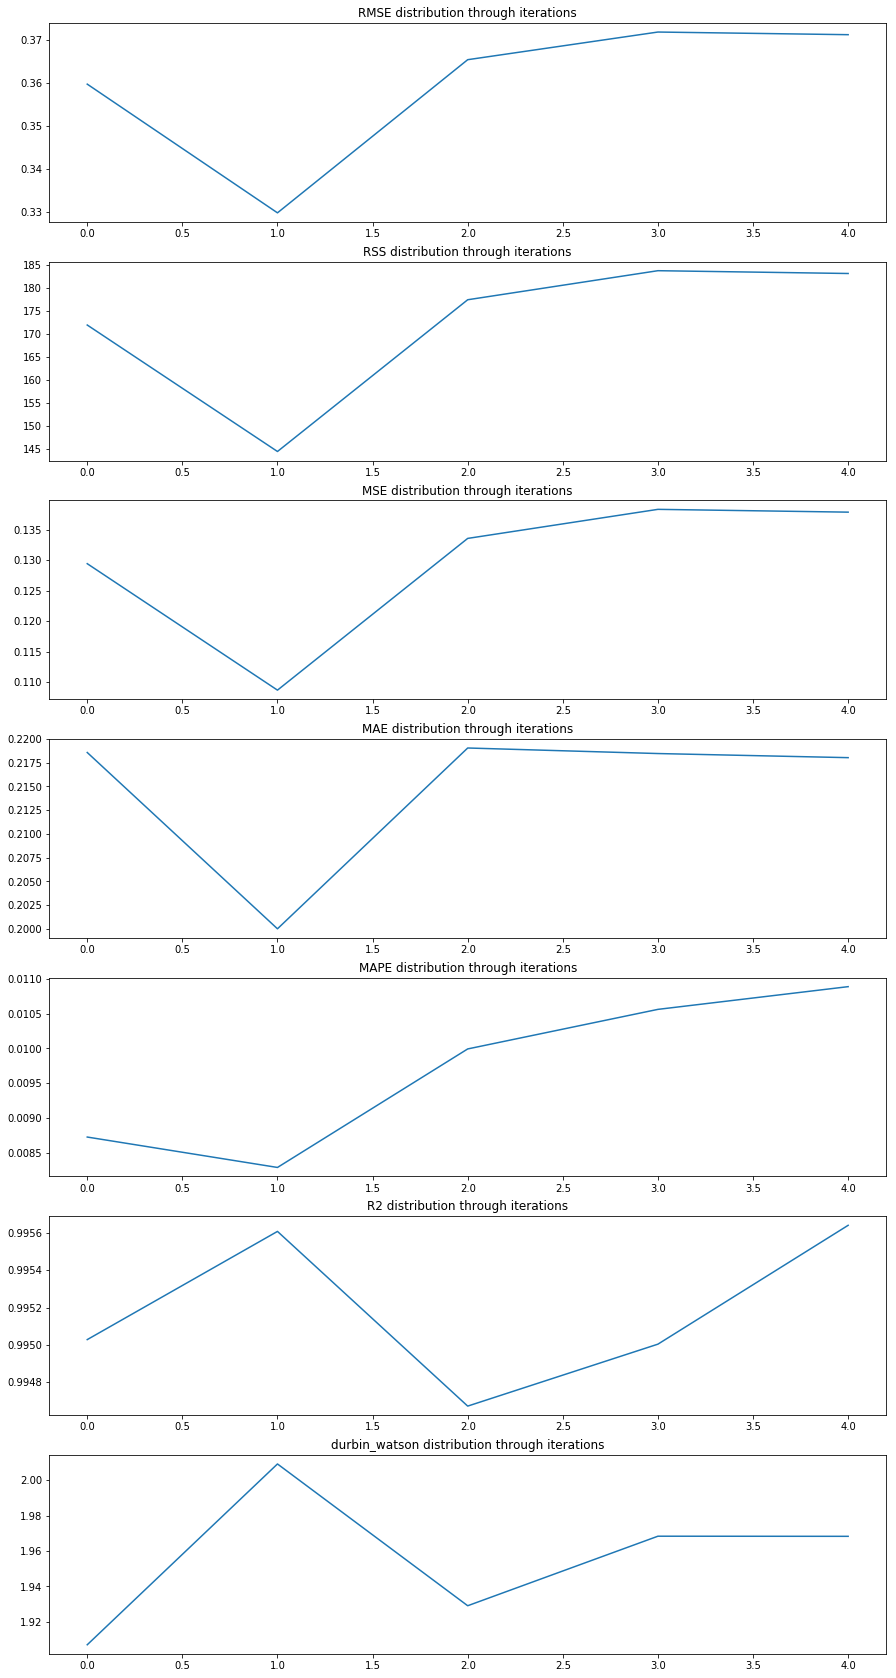

In [66]:
fig, axs = plt.subplots(nrows=all_metrics_df.shape[1], ncols=1, figsize=(15, 30))

for idx, metric_title in enumerate(all_metrics_df.columns):
    axs[idx].plot(all_metrics_df[metric_title])
    axs[idx].set_title('{} distribution through iterations'.format(metric_title))

#### Тестувальні вибірки

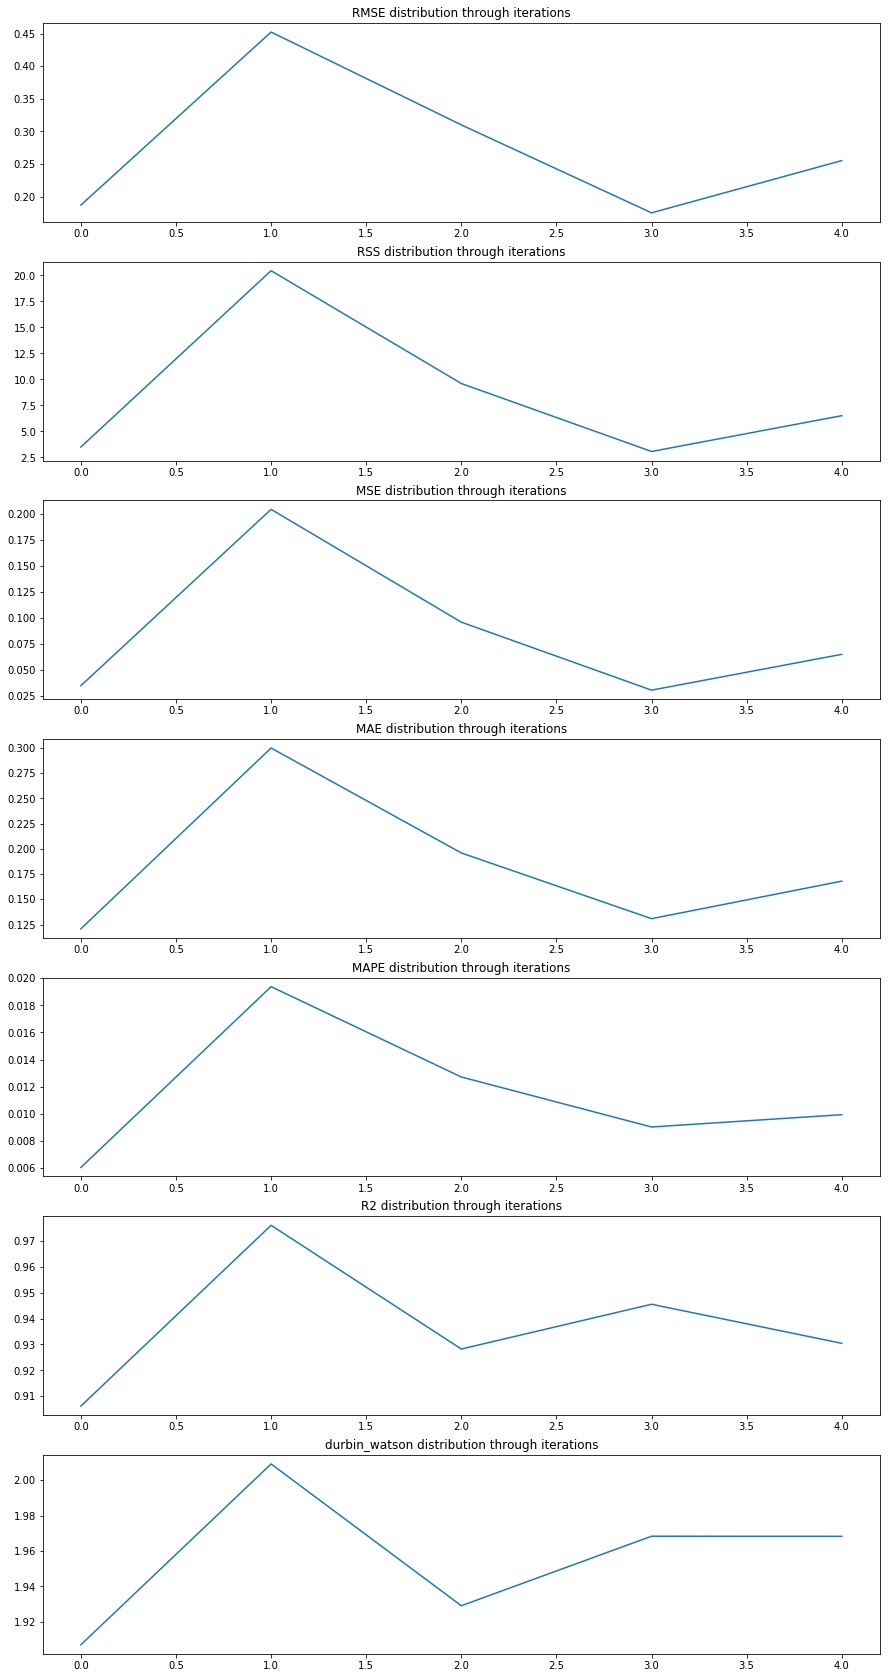

In [67]:
fig, axs = plt.subplots(nrows=all_metrics_df.shape[1], ncols=1, figsize=(15, 30))

for idx, metric_title in enumerate(all_metrics_df.columns):
    axs[idx].plot(all_metrics_df_test[metric_title])
    axs[idx].set_title('{} distribution through iterations'.format(metric_title))